## Test sample of measured galaxies

Portions of the code were developed with the assistance of AI-based programming tools (e.g. Copilot, ChatGPT). All generated code was reviewed, tested, and validated by the authors to ensure scientific accuracy and correctness.


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
cmap = sns.color_palette("mako", as_cmap=True)

In [122]:
import os
os.chdir('/Users/Megan/Desktop/Desktop/galaxy-morphology/sandbox')
print(os.getcwd())
print(os.listdir())

/Users/Megan/Desktop/Desktop/galaxy-morphology/sandbox
['.DS_Store', 'InclinationSample.ipynb', 'subset_data.h5']


In [123]:
import pandas as pd

data = pd.read_hdf('subset_data.h5', key='galaxies')
data.head()

,GALAXY,BA_LEDA,PA_LEDA,RA_LEDA,DEC_LEDA,MORPHTYPE,D26,ASCALE_r,quality_flag,eta_g,eta_r,eta_z,pa_g,pa_r,pa_z
0,PGC1283207,0.724436,152.199997,228.377086,5.423202,S?,0.494706,6.950939,0,0.430178,0.425136,0.376875,153.632730,152.678786,153.881916
1,PGC1310416,0.781628,159.259995,202.544438,6.934594,Sc,0.553505,13.288824,0,0.431894,0.406683,0.373844,8.206315,5.294763,2.501010
2,SDSSJ145059.93+135143.0,0.663743,44.570000,222.749787,13.861911,S?,0.370675,7.318237,0,0.242208,0.264462,0.216540,51.596355,54.218038,51.158810
3,PGC1742504,0.251189,84.970001,182.088808,25.602276,Sbc,0.888320,13.458540,2,0.478031,0.437060,0.428805,85.987438,86.442334,85.619140
4,SDSSJ173412.71+572041.6,0.533335,152.580002,263.552935,57.344907,S?,0.446012,8.839746,0,0.309577,0.304468,0.268434,154.617156,151.939023,149.756252


There are six measurements for eta, using `ASCALE_{}` as the scaling values `[0.75,1., 1.5, 2.0, 2.5,3.0]`. In the next cell we'll select the fiducial scaling value of 1. But in principle you can compare the different scalings to see if anything changes for eta when the fit scale length changes.

This also works for PAs, see the next next cell.

In [124]:
eta_g = np.array([data['eta_g']])
#eta_r = np.array([data['ETA_r'][i][1] for i in data['ETA_r'].index])
#eta_z = np.array([data['ETA_z'][i][1] for i in data['ETA_z'].index])
print(eta_g[eta_g>0].size)

115925


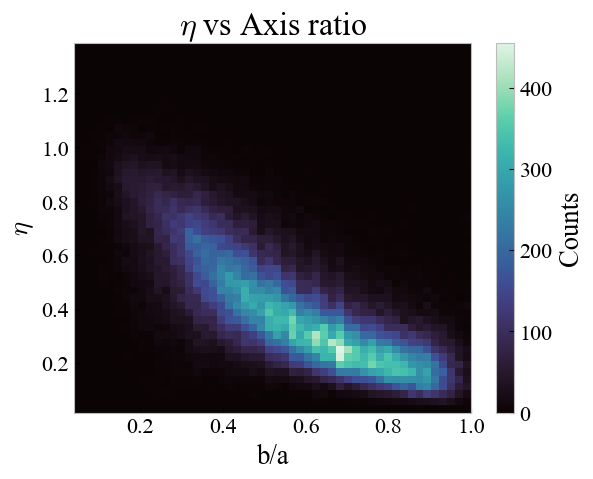

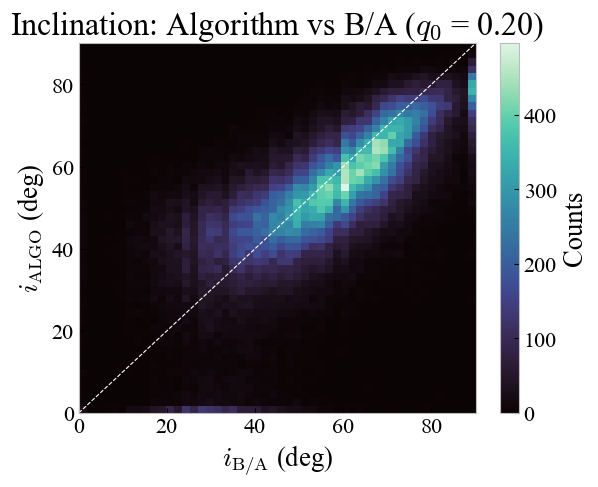

In [113]:
# Notes:
# - Uses the standard oblate disk formula with intrinsic thickness q0:
#     cos^2 i = (q^2 - q0^2) / (1 - q0^2),  i in [0°, 90°]
#   where q = b/a = BA_LEDA. We clip invalids and set i=90° if q < q0.
# - Set q0 per your preference (common choices: 0.13–0.25; I default to 0.2).
# - If your dataframe already has a column with your algorithm’s inclination
#   (degrees), name it 'INC_ALGO_deg'. If not, fill it using your code where marked.
#
# This cell will:
#   1) Load your HDF shown in the screenshot.
#   2) Add an inclination column from BA ('INC_BA_deg').
#   3) If 'INC_ALGO_deg' exists, compute residuals and quick diagnostics,
#      and plot comparisons.
#
import numpy as np
from scipy.optimize import root_scalar


df = pd.read_hdf('subset_data.h5', key='galaxies')

good = df.loc[df['quality_flag'] <= 3].copy()

# Extract both columns consistently
ba = good['BA_LEDA'].to_numpy()
eta_r = good['eta_r'].to_numpy()
eta_g = good['eta_g'].to_numpy()
eta_z = good['eta_z'].to_numpy()

Q0_DEFAULT = 0.20

def inc_from_ba(q, q0=Q0_DEFAULT):
    q = np.asarray(q, dtype=float)
    q0 = float(q0)
    out = np.full_like(q, np.nan, dtype=float)
    # Valid where q >= q0 and q <= 1
    mask_valid = (~np.isnan(q)) & (q >= q0) & (q <= 1.0)
    # Clip tiny numeric issues
    num = np.clip(q[mask_valid]**2 - q0**2, 0.0, None)
    den = max(1.0 - q0**2, 1e-12)
    cos2 = np.clip(num / den, 0.0, 1.0)
    inc = np.degrees(np.arccos(np.sqrt(cos2)))
    out[mask_valid] = inc
    # If q < q0, set to edge-on (90°)
    mask_edge = (~np.isnan(q)) & (q < q0)
    out[mask_edge] = 90.0
    # If q > 1 (bad entries), set to face-on (0°)
    mask_face = (~np.isnan(q)) & (q > 1.0)
    out[mask_face] = 0.0
    return out

good['INC_BA_deg'] = inc_from_ba(ba, q0=Q0_DEFAULT)


def cos_plus_exp(x_deg, A, B, D,C, E, F):
        x_rad = np.deg2rad(x_deg)
        return A * np.cos(B * x_rad+C) + D + E * np.exp(F * x_deg)

def find_inclination_from_eta(eta_target, A, B, D, C, E, F,
                                search_range=(0, 90), tol=1e-6, verbose=False):
    def f(x):
        return cos_plus_exp(x, A, B, C,D, E, F) - eta_target

    x_min, x_max = search_range
    fmin, fmax = f(x_min), f(x_max)
    if np.sign(fmin) == np.sign(fmax):
        if verbose:
            print("Eta target is outside model range, extrapolating.")
        x_grid = np.linspace(x_min, x_max, 2000)
        return x_grid[np.argmin(np.abs(f(x_grid)))]

    sol = root_scalar(f, bracket=[x_min, x_max], method='brentq', xtol=tol)
    if not sol.converged:
        raise RuntimeError("Root finding failed to converge.")
    return sol.root
A=-0.24444315 
B=-2.27534356  
C=8.59288841 
D=-1
E=0.94045508  
F=0.00969384

inc_list_r=[]
inc_list_z=[]
inc_list_g=[]
for eta in eta_r:
    inc_bt = float(
        find_inclination_from_eta(
            eta, A, B, C, D, E, F, verbose=False
        )
    )
    inc_list_r.append(inc_bt)
for eta in eta_z:
    inc_bt = float(
        find_inclination_from_eta(
            eta, A, B, C, D, E, F, verbose=False
        )
    )
    inc_list_z.append(inc_bt)
for eta in eta_g:
    inc_bt = float(
        find_inclination_from_eta(
            eta, A, B, C, D, E, F, verbose=False
        )
    )
    inc_list_g.append(inc_bt)
x=[0,90]
# Plot 1: BA vs inclination from BA 
fig1=plt.figure()
plt.hist2d(ba, eta_g, bins=50, cmap=cmap)
plt.colorbar(label='Counts')
plt.xlabel(r'b/a')
plt.ylabel(r'$\eta$')
plt.title(r'$\eta$ vs Axis ratio')
plt.grid(None)
plt.show()

# Plot 2: Algorithm vs BA inclinations
fig2=plt.figure()
plt.hist2d(good['INC_BA_deg'], inc_list, bins=50, cmap=cmap)
plt.colorbar(label='Counts')
# 1:1 line
plt.plot(x,x, color='white', linestyle='--', linewidth=0.8, label='1:1 line')
plt.grid(None)
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$i_{\text{ALGO}}$ (deg)')
plt.title(r'Inclination: Algorithm vs B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))

plt.show()



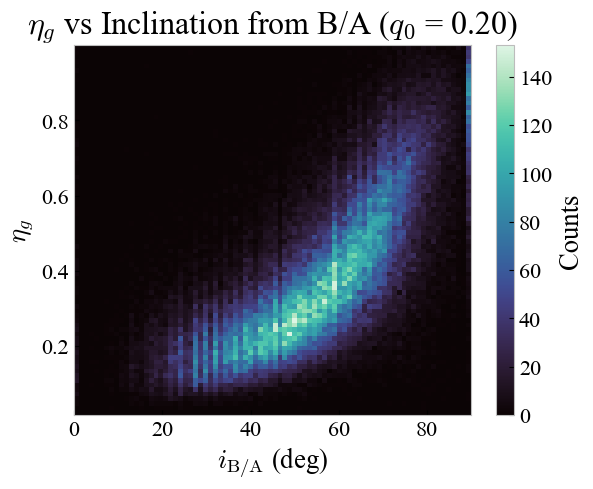

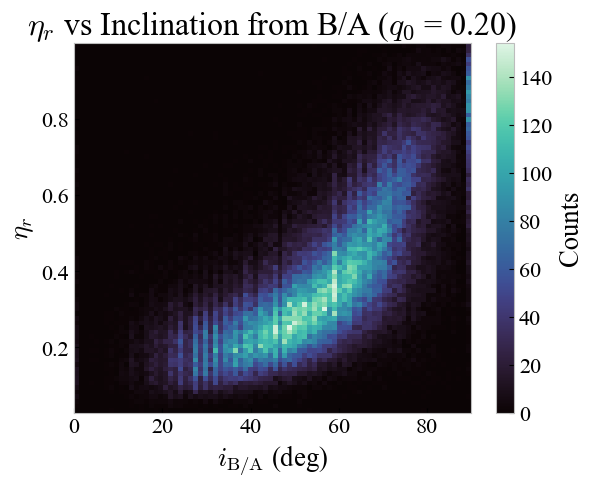

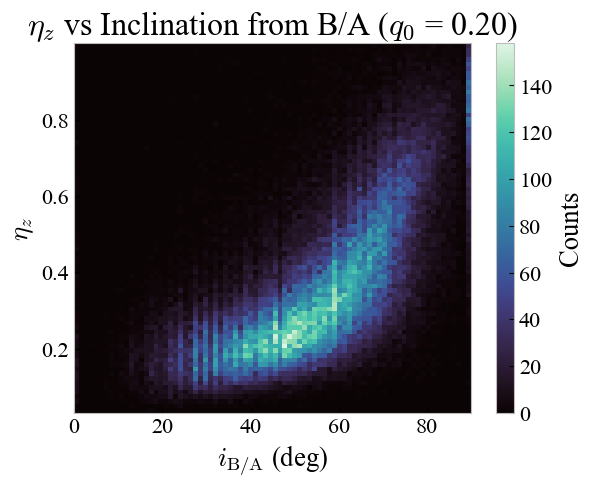


=== Cosine + Exponential Fit ===
A = -0.0928 ± 0.0097
B = -3.3532 ± 0.1590
C = 8.5632 ± 0.1370
E = 0.1776 ± 0.0109
F = 0.0151 ± 0.0008
RMSE = 0.1241


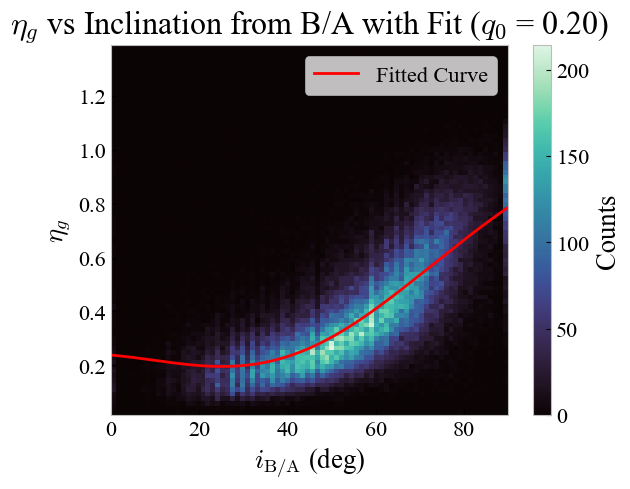

In [103]:
from scipy.optimize import curve_fit
eta_g = good['eta_g'].to_numpy()
eta_r = good['eta_r'].to_numpy()
eta_z = good['eta_z'].to_numpy()
eta_g_1=eta_g[eta_g<1]
eta_r_1=eta_r[eta_r<1]
eta_z_1=eta_z[eta_z<1]
inc_ba_1=good['INC_BA_deg'][eta_g<1]
inc_ba_1=inc_ba_1.to_numpy()
inc_ba_2=good['INC_BA_deg'][eta_r<1]    
inc_ba_2=inc_ba_2.to_numpy()
inc_ba_3=good['INC_BA_deg'][eta_z<1]
inc_ba_3=inc_ba_3.to_numpy()

plt.hist2d(inc_ba_1, eta_g_1, bins=80, cmap=cmap)
plt.colorbar(label='Counts')
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$\eta_g$')
plt.title(r'$\eta_g$ vs Inclination from B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
plt.grid(None)
plt.show()  

plt.hist2d(inc_ba_2, eta_r_1, bins=80, cmap=cmap)
plt.colorbar(label='Counts')
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$\eta_r$')
plt.title(r'$\eta_r$ vs Inclination from B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
plt.grid(None)
plt.show()

plt.hist2d(inc_ba_3, eta_z_1, bins=80, cmap=cmap)
plt.colorbar(label='Counts')
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$\eta_z$')
plt.title(r'$\eta_z$ vs Inclination from B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
plt.grid(None)
plt.show()

def cos_plus_exp(x_deg, A, B, C, E, F):
    """
    A * cos(B * radians(x) + C) + D + E * exp(F * x)
    Combines an oscillatory term with a rising exponential tail.
    """
    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C)  + E * np.exp(F * x_deg)


# ================================================
# 2) Initial guesses and bounds
# ================================================
p0 = [-0.0, -1.65, 6.43,  0.01, 0.05]

lower = [-2.0, -10.0, -10.0, -10.0, -1.0]
upper = [ 2.0,  10.0,  10.0,  10.0,  1.0]

params, covariance = curve_fit(
    cos_plus_exp, inc_ba_1, eta_g_1,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000
)

A_fit, B_fit, C_fit,  E_fit, F_fit = params
errors = np.sqrt(np.diag(covariance))

print("\n=== Cosine + Exponential Fit ===")
print(f"A = {A_fit:.4f} ± {errors[0]:.4f}")
print(f"B = {B_fit:.4f} ± {errors[1]:.4f}")
print(f"C = {C_fit:.4f} ± {errors[2]:.4f}")

print(f"E = {E_fit:.4f} ± {errors[3]:.4f}")
print(f"F = {F_fit:.4f} ± {errors[4]:.4f}")

# ================================================
# 4) Generate fit curve for plotting
# ================================================
inc_fit = np.linspace(0, 90, 500)

eta_fit = cos_plus_exp(inc_fit, *params)
xdata = inc_ba_1
ydata = eta_g_1
# Compute residuals and RMSE for diagnostics
residuals = ydata - cos_plus_exp(xdata, *params)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.4f}")

plt.plot(inc_fit, eta_fit, color='red', label='Fitted Curve')
plt.hist2d(good['INC_BA_deg'], good['eta_g'], bins=80, cmap=cmap)
plt.colorbar(label='Counts')
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$\eta_g$')
plt.title(r'$\eta_g$ vs Inclination from B/A with Fit ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
plt.grid(None)
plt.legend()
plt.show()





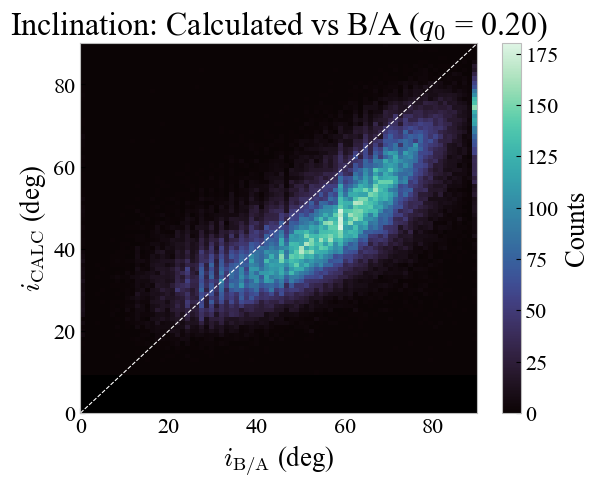

9.361871625076448 0.01598324283293313


In [105]:
A=-456866.7090
B=0.0010
C=0.0
D=456866.7090
A = -2.399999999999977 
B = 0.5000000000000031 
C= 0.0 
D = 2.399999999999977
def find_inc(eta,A,B,C,D):
    if eta>1.2:
        eta=1.2
    return np.degrees(np.arccos(np.sqrt((eta - D)/A)) - C)/B
eta_g = good['eta_g'].to_numpy()
inc_list=[]
for eta in eta_g:
    inc_bt = float(
        find_inc(
            eta, A, B, C, D
        )
    )
    inc_list.append(inc_bt)
x=[0,90]

plt.hist2d(good['INC_BA_deg'], inc_list, bins=80, cmap=cmap)
plt.colorbar(label='Counts')
# 1:1 line
plt.plot(x,x, color='white', linestyle='--', linewidth=0.8, label='1:1 line')
plt.grid(None)
plt.xlim(0, 90)
plt.ylim(0, 90)
plt.gca().set_facecolor('black')
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$i_{\text{CALC}}$ (deg)')
plt.title(r'Inclination: Calculated vs B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
plt.show()
print(np.min(inc_list), np.min(eta_g))


A = -2.399999999999994 B = 0.5000000000000008 C = 0.0 D = 2.399999999999994


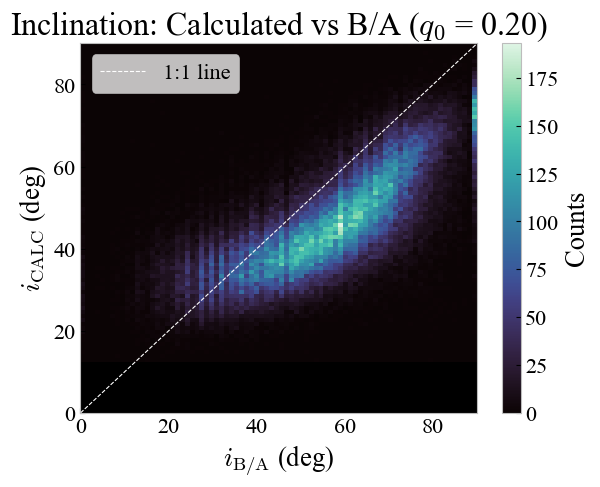

In [110]:
eta_max = 1.2

def cos2_fixedC(x_deg, B):
    x_rad = np.deg2rad(x_deg)
    s2 = np.sin(B * np.pi/2)**2
    if s2 < 1e-8:
        s2 = 1e-8
    A = -eta_max / s2
    D = -A
    return A * np.cos(B * x_rad)**2 + D

xdata = inc_ba_2
ydata = eta_r_1

p0    = [1.0]
lower = [0.5]   # <--- keep B near 1
upper = [1.5]

params, cov = curve_fit(
    cos2_fixedC, xdata, ydata,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000
)

B_fit = params[0]
s2    = np.sin(B_fit * np.pi/2)**2
if s2 < 1e-8:
    s2 = 1e-8
A_fit = -eta_max / s2
D_fit = -A_fit
C_fit = 0.0

print("A =", A_fit, "B =", B_fit, "C =", C_fit, "D =", D_fit)

ETA_MAX = 1.2  # same as above

def invert_cos2_eta(eta, A, B, C, D):
    """
    Invert η = A cos^2(B i + C) + D  for i (in degrees).

    Assumes we want the principal solution 0° <= i <= 90°.
    """
    # clamp η to the allowed range
    eta_clamped = np.clip(eta, 0.0, ETA_MAX)

    # argument of sqrt must be in [0,1]
    arg = (eta_clamped - D) / A
    arg = np.clip(arg, 0.0, 1.0)

    angle = np.arccos(np.sqrt(arg))   # radians
    i_rad = (angle - C) / B           # solve for i (radians)
    i_deg = np.degrees(i_rad)
    return i_deg
A, B, C, D = A_fit, B_fit, C_fit, D_fit

eta_r = good['eta_r'].to_numpy()
inc_list = [invert_cos2_eta(e, A, B, C, D) for e in eta_r]

x = [0, 90]

plt.hist2d(good['INC_BA_deg'], inc_list, bins=80, cmap=cmap)
plt.colorbar(label='Counts')
plt.plot(x, x, color='white', linestyle='--', linewidth=0.8, label='1:1 line')
plt.xlabel(r'$i_{\text{B/A}}$ (deg)')
plt.ylabel(r'$i_{\text{CALC}}$ (deg)')
plt.xlim(0, 90)
plt.ylim(0, 90)
plt.gca().set_facecolor('black')
plt.title(r'Inclination: Calculated vs B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
plt.grid(None)
plt.legend()
plt.show()



=== cos^2 fit with η(0)=0, η(90°)=1.2 ===
B = 0.2000 ± 0.0211
C = -0.0400 ± 0.0046
RMSE = 0.1823


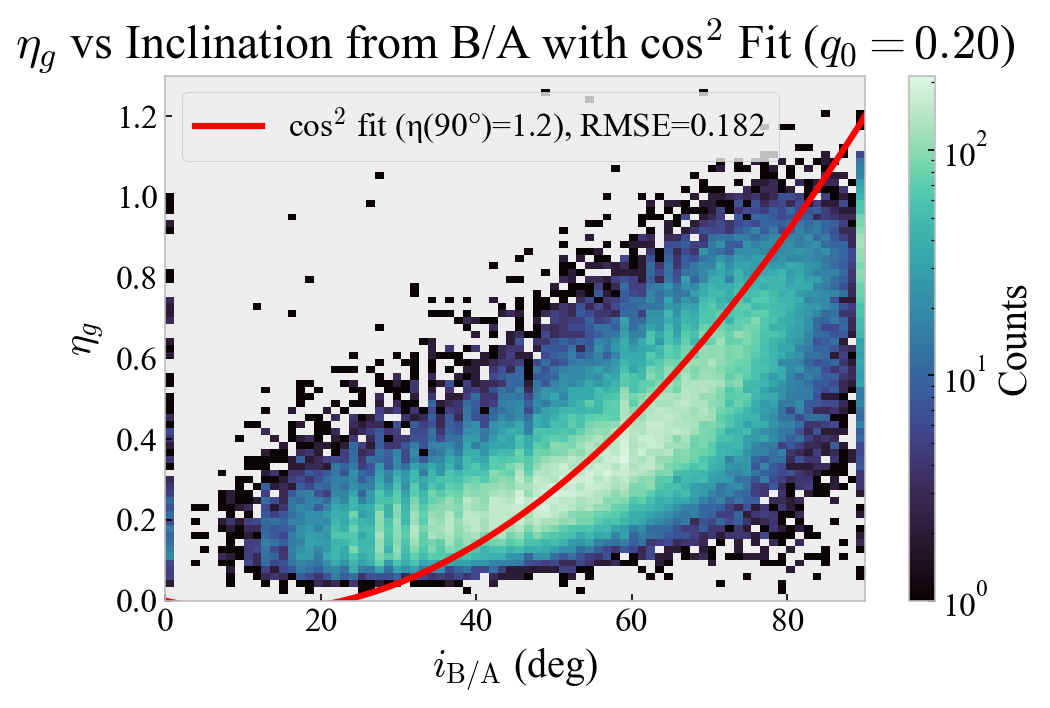

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

eta_max = 1.2  # fixed edge-on value

def cos2_two_point(x_deg, B, C):
    """
    η(i) = A cos^2(B i + C) + D
    with constraints:
        η(0)   = 0
        η(90°) = eta_max  (fixed = 1.2)
    """
    # everything in radians
    cosC   = np.cos(C)
    cos90  = np.cos(B * np.pi/2 + C)

    denom = cos90**2 - cosC**2
    # avoid division by nearly zero
    if np.abs(denom) < 1e-6:
        denom = np.sign(denom) * 1e-6

    A = eta_max / denom
    D = -A * cosC**2

    x_rad = np.deg2rad(x_deg)
    return A * np.cos(B * x_rad + C)**2 + D


# ---- fit B, C ----
xdata = inc_ba_1
ydata = eta_g_1

p0    = [1.0, 0.0]           # B, C initial guesses
lower = [0.2, -np.pi]
upper = [2.0,  np.pi]

params, cov = curve_fit(
    cos2_two_point, xdata, ydata,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000,
)

B_fit, C_fit = params
B_err, C_err = np.sqrt(np.diag(cov))

print("\n=== cos^2 fit with η(0)=0, η(90°)=1.2 ===")
print(f"B = {B_fit:.4f} ± {B_err:.4f}")
print(f"C = {C_fit:.4f} ± {C_err:.4f}")

# RMSE
resid = ydata - cos2_two_point(xdata, *params)
rmse = np.sqrt(np.mean(resid**2))
print(f"RMSE = {rmse:.4f}")

# ---- plot ----
plt.rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
h = ax.hist2d(good['INC_BA_deg'], good['eta_g'],
              bins=80, cmap=cmap, norm=LogNorm())
plt.colorbar(h[3], ax=ax, label='Counts')

inc_fit = np.linspace(0, 90, 500)
eta_fit = cos2_two_point(inc_fit, *params)

ax.plot(inc_fit, eta_fit, color='red', lw=3,
        label=rf'cos$^2$ fit (η(90°)=1.2), RMSE={rmse:.3f}')

ax.set_xlim(0, 90)
ax.set_ylim(0, 1.3)
ax.set_xlabel(r'$i_{\mathrm{B/A}}$ (deg)')
ax.set_ylabel(r'$\eta_g$')
ax.set_title(r'$\eta_g$ vs Inclination from B/A with cos$^2$ Fit '
             f'($q_0={Q0_DEFAULT:.2f}$)')
ax.legend(loc='upper left', frameon=True)
ax.grid(False)
fig.tight_layout()
plt.show()


Fit params: [-6.96978218e-02 -4.57038535e+00  4.03485414e+00  9.99994228e+00
  8.12078668e-04]
RMSE = 0.126


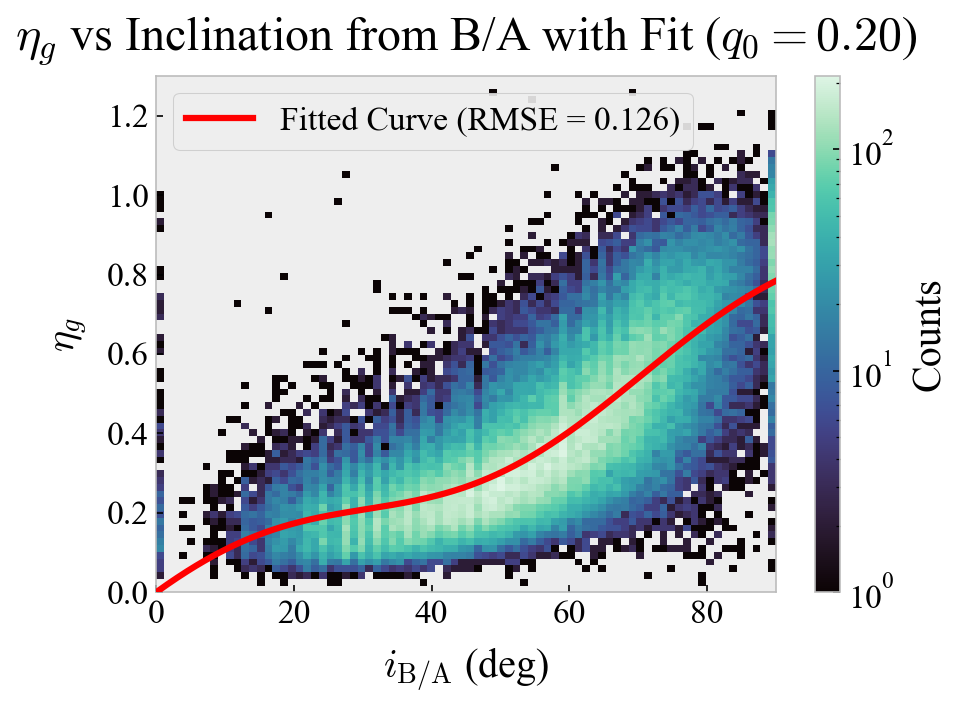

In [39]:
def cos_plus_exp_0(i_deg, A, B, C, E, F):
    """
    Cosine + exponential constrained to pass through (0, 0).

    f(i) = A cos(B i_rad + C) + D + E exp(F i_deg)
    with D = -A cos(C) - E  =>  f(0) = 0 exactly.
    """
    i_rad = np.deg2rad(i_deg)
    D = -A * np.cos(C) - E     # constraint enforcing f(0)=0
    return A * np.cos(B * i_rad + C) + D + E * np.exp(F * i_deg)

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

xdata = good['INC_BA_deg'].to_numpy()
ydata = good['eta_g'].to_numpy()

# Initial guesses (based on your old ones, just dropping D)
p0    = [-0.3, -1.65, 6.43, 0.01, 0.05]   # A, B, C, E, F
lower = [-2.0, -10.0, -10.0, -10.0, -1.0]
upper = [ 2.0,  10.0,  10.0,  10.0,  1.0]

params, cov = curve_fit(
    cos_plus_exp_0,
    xdata, ydata,
    p0=p0, bounds=(lower, upper),
    maxfev=100_000
)

A_fit, B_fit, C_fit, E_fit, F_fit = params
print("Fit params:", params)

residuals = ydata - cos_plus_exp_0(xdata, *params)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.3f}")

plt.rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})

fig, ax = plt.subplots(figsize=(6.5, 5), dpi=150)

# 2D histogram
hb = ax.hist2d(xdata, ydata, bins=80, cmap=cmap, norm=LogNorm())
cbar = fig.colorbar(hb[3], ax=ax)
cbar.set_label('Counts', labelpad=8)

# Fitted curve
inc_fit = np.linspace(0, 90, 500)
eta_fit = cos_plus_exp_0(inc_fit, *params)

ax.plot(
    inc_fit, eta_fit,
    color="red", lw=3, zorder=3,
    label=fr'Fitted Curve (RMSE = {rmse:.3f})'
)

ax.set_xlim(0, 90)
ax.set_ylim(0.0, 1.3)

ax.set_xlabel(r'$i_{\mathrm{B/A}}$ (deg)', labelpad=8)
ax.set_ylabel(r'$\eta_g$', labelpad=8)
ax.set_title(
    rf'$\eta_g$ vs Inclination from B/A with Fit ($q_0 = {Q0_DEFAULT:.2f}$)',
    pad=12
)

leg = ax.legend(frameon=True, loc="upper left")
leg.get_frame().set_alpha(0.9)
ax.grid(False)
fig.tight_layout()
plt.show()


In [22]:
print("INC_alg_deg has NaN:", good['INC_alg_deg'].isna().mean())
print("min/max INC_alg_deg:", good['INC_alg_deg'].min(), good['INC_alg_deg'].max())
print("min/max eta_g:", good['eta_g'].min(), good['eta_g'].max())
print("min/max eta_mono:", eta_mono.min(), eta_mono.max())

INC_alg_deg has NaN: 0.18133737029194494
min/max INC_alg_deg: 24.44617359090186 89.99952940733694
min/max eta_g: 0.01598324283293313 1.3869844025023386


NameError: name 'eta_mono' is not defined

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_30632/411022886.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper left', fontsize=8, frameon=False)


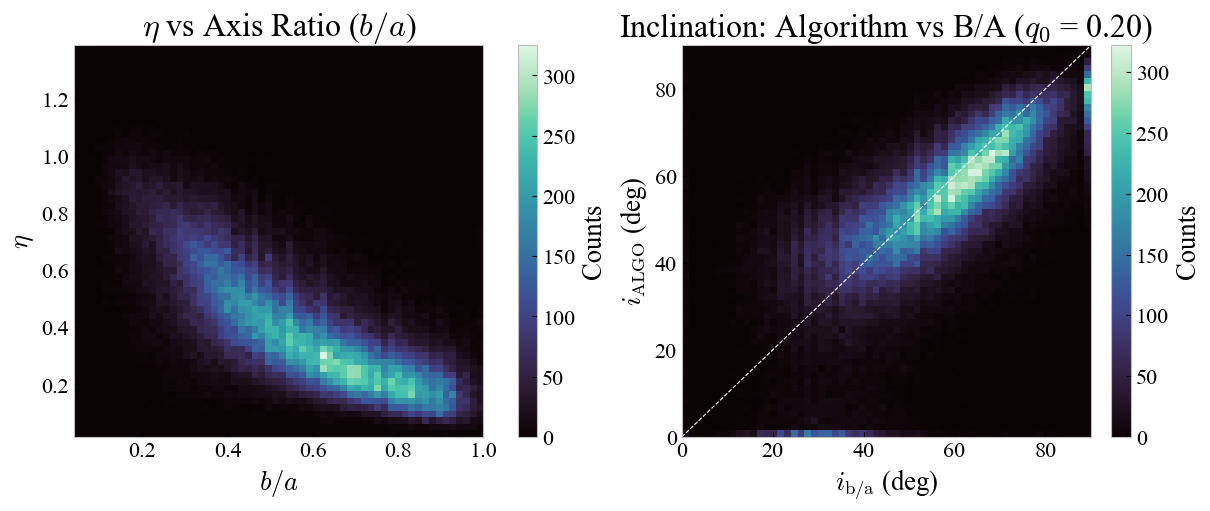

104369


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cmap = sns.color_palette("mako", as_cmap=True)

x = [0, 90]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/ba_incl_115000_flag3_grid_edge.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(ba, eta_g, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[0].grid(False)
    axes[0].set_xlabel(r'$b/a$')
    axes[0].set_ylabel(r'$\eta$')
    axes[0].set_title(r'$\eta$ vs Axis Ratio ($b/a$)')
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    
    

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = axes[1].hist2d(good['INC_BA_deg'], inc_list, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[1].grid(False)
    axes[1].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    axes[1].legend(loc='upper left', fontsize=8, frameon=False)
    axes[1].set_xlabel(r'$i_{\text{b/a}}$ (deg)')
    axes[1].set_ylabel(r'$i_{\text{ALGO}}$ (deg)')
    axes[1].set_title(r'Inclination: Algorithm vs B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
    fig.colorbar(h2[3], ax=axes[1], label='Counts')
    
    
    pp.savefig(fig)
    

plt.show()
print(len(ba))

In [119]:
error_inc=np.array(inc_list)-good['INC_BA_deg']
avg_error_inc=np.median(np.abs(error_inc))
print(avg_error_inc)

6.882830779184296


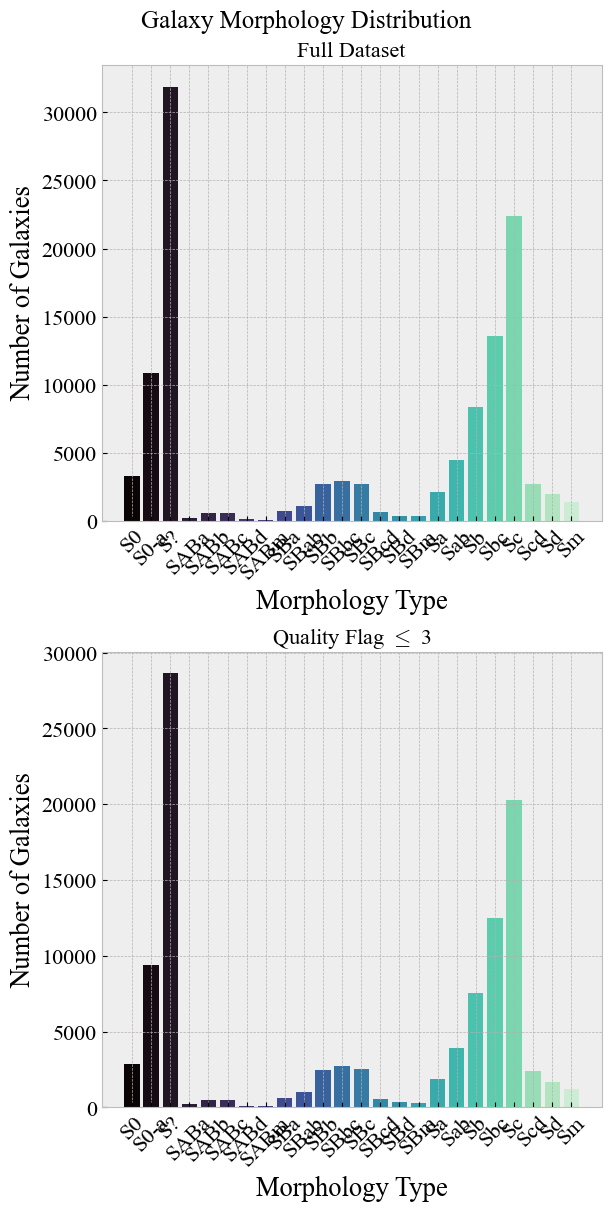

In [120]:
# Full dataset
morph_counts = df['MORPHTYPE'].value_counts().sort_index()

# Filtered dataset (good quality)
good_morph_counts = good['MORPHTYPE'].value_counts().sort_index()
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})


fig, axes = plt.subplots(2,1, figsize=(6, 12), constrained_layout=True)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/new_morphology_distributiontitle1.pdf') as pp:
    # --- Full dataset ---
    N = len(morph_counts)
    colors = [cmap(i/N) for i in range(N)]  # map each bar to a color
    axes[0].bar(x=morph_counts.index, height=morph_counts.values, color=colors)
    axes[0].set_xlabel("Morphology Type")
    axes[0].set_ylabel("Number of Galaxies")
    axes[0].set_title("Full Dataset", fontsize=16)
    axes[0].tick_params(axis='x', rotation=45)  # rotate x labels
    
    # --- Good-quality dataset ---
    N_good = len(good_morph_counts)
    colors_good = [cmap(i/N_good) for i in range(N_good)]
    axes[1].bar(x=good_morph_counts.index, height=good_morph_counts.values, color=colors_good)
    axes[1].set_xlabel("Morphology Type")
    axes[1].set_ylabel("Number of Galaxies")
    axes[1].set_title(r"Quality Flag $\leq$ 3", fontsize=16)
    axes[1].tick_params(axis='x', rotation=45)  # rotate x labels
    plt.suptitle("Galaxy Morphology Distribution", fontsize=18)
    
    pp.savefig(fig)
plt.show()

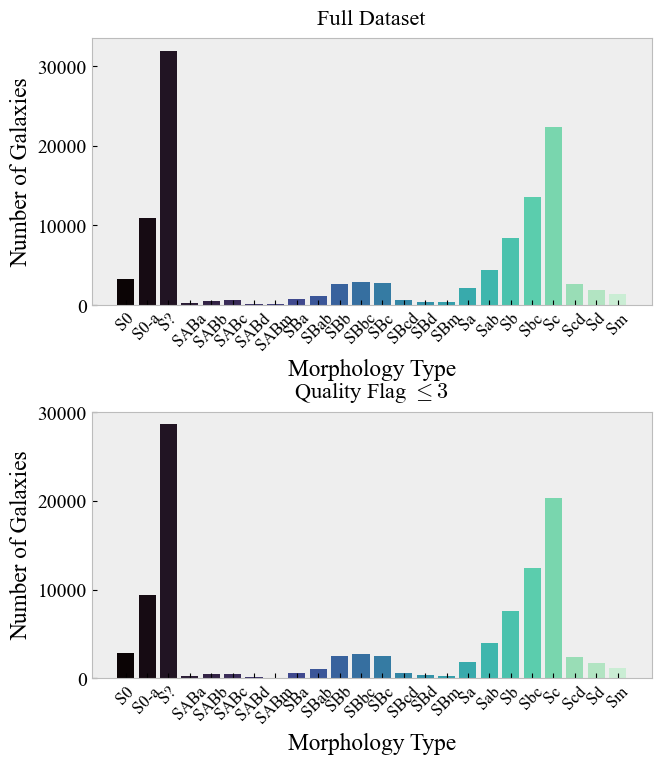

In [148]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# --- Counts ---
morph_counts = df['MORPHTYPE'].value_counts().sort_index()
good_morph_counts = good['MORPHTYPE'].value_counts().sort_index()

# --- Matplotlib font + style ---
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# --- Figure and grid setup ---
fig, ax = plt.subplots(
    2, 1,
    figsize=(7, 8),                    # shorter, balanced aspect
    constrained_layout=False
)
fig.subplots_adjust(
    hspace=0.4, left=0.15, right=0.95, top=0.92, bottom=0.12
)  # adds clear margins

# --- Full dataset ---
N = len(morph_counts)
colors = [cmap(i / N) for i in range(N)]
bars1 = ax[0].bar(
    morph_counts.index, morph_counts.values,
    color=colors, edgecolor='none'
)
ax[0].set_title("Full Dataset", fontsize=16, pad=10)
ax[0].set_xlabel("Morphology Type")
ax[0].set_ylabel("Number of Galaxies")
ax[0].tick_params(axis='x', rotation=45, labelsize=12)
ax[0].grid(False)
for b in bars1:
    b.set_rasterized(True)

# --- Good-quality dataset ---
N_good = len(good_morph_counts)
colors_good = [cmap(i / N_good) for i in range(N_good)]
bars2 = ax[1].bar(
    good_morph_counts.index, good_morph_counts.values,
    color=colors_good, edgecolor='none'
)
ax[1].set_title(r"Quality Flag $\leq 3$", fontsize=16, pad=10)
ax[1].set_xlabel("Morphology Type")
ax[1].set_ylabel("Number of Galaxies")
ax[1].tick_params(axis='x', rotation=45, labelsize=12)
ax[1].grid(False)
for b in bars2:
    b.set_rasterized(True)

# --- Global title ---


# --- Save cleanly (no bbox_inches='tight') ---
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/new_morphology_distributiontitle2.pdf') as pp:
    pp.savefig(fig, dpi=300)

plt.show()


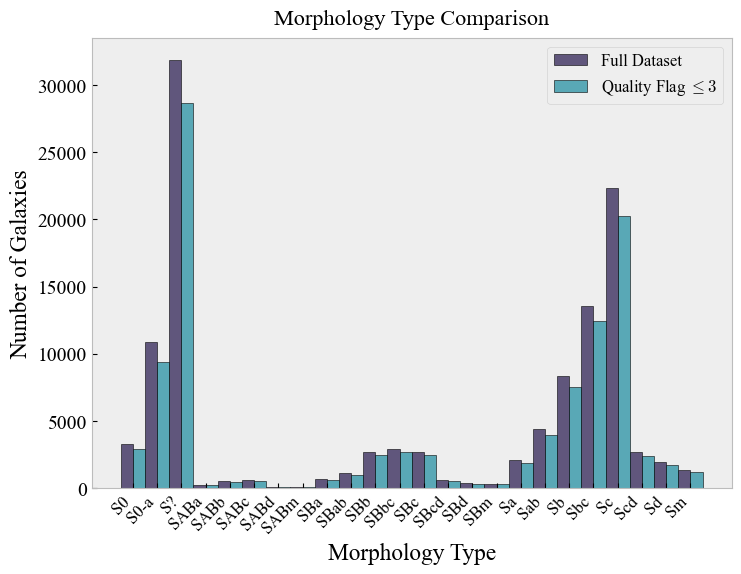

In [158]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# --- Counts ---
morph_counts = df['MORPHTYPE'].value_counts().sort_index()
good_morph_counts = good['MORPHTYPE'].value_counts().sort_index()

# --- Align the two series so missing categories get 0 ---
all_types = sorted(set(morph_counts.index) | set(good_morph_counts.index))
morph_values = morph_counts.reindex(all_types, fill_value=0)
good_values = good_morph_counts.reindex(all_types, fill_value=0)

# --- Matplotlib font + style ---
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# --- Figure setup ---
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)

cmap = sns.color_palette("mako", as_cmap=True)

# --- Plot overlapping bars ---
width = 0.5  # bar width for offset plotting
x = np.arange(len(all_types))

bars1 = ax.bar(
    x - width/2, morph_values.values, width=width,
    color=cmap(0.23), alpha=0.8, label="Full Dataset", edgecolor='black'
)
bars2 = ax.bar(
    x + width/2, good_values.values, width=width,
    color=cmap(0.6), alpha=0.8, label=r"Quality Flag $\leq 3$", edgecolor='black'
)

# --- Axes formatting ---
ax.set_title("Morphology Type Comparison", fontsize=16, pad=10)
ax.set_xlabel("Morphology Type")
ax.set_ylabel("Number of Galaxies")
ax.set_xticks(x)
ax.set_xticklabels(all_types, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(False)

# --- Rasterize for lightweight PDF ---
for b in bars1 + bars2:
    b.set_rasterized(True)

# --- Save cleanly ---
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/new_morphology_comparison_overplotted.pdf') as pp:
    pp.savefig(fig, dpi=300)

plt.show()


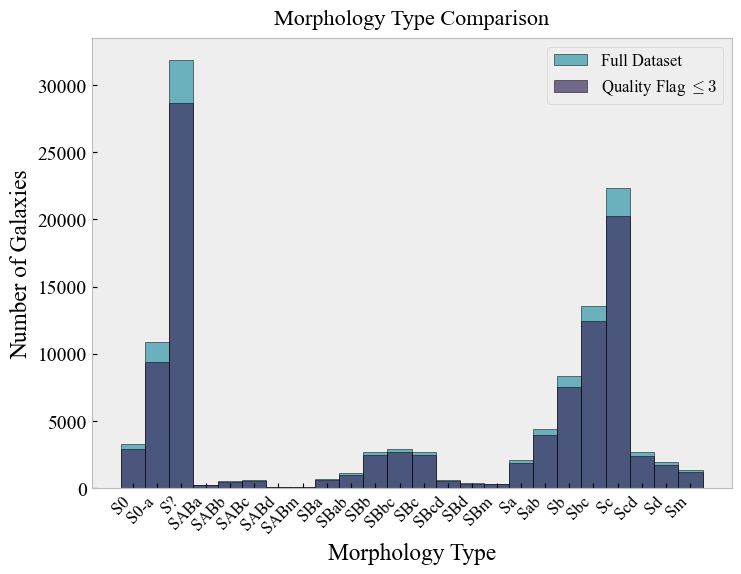

In [155]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import numpy as np

# --- Counts ---
morph_counts = df['MORPHTYPE'].value_counts().sort_index()
good_morph_counts = good['MORPHTYPE'].value_counts().sort_index()

# --- Combine categories ---
all_types = sorted(set(morph_counts.index) | set(good_morph_counts.index))
morph_values = morph_counts.reindex(all_types, fill_value=0)
good_values = good_morph_counts.reindex(all_types, fill_value=0)

# --- Matplotlib font + style ---
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman']
})

# --- Figure setup ---
fig, ax = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.15)



# --- Overlaid histograms ---
bins = np.arange(len(all_types) + 1) - 0.5  # so each category has its own bin

ax.hist(
    np.repeat(all_types, morph_values.values.astype(int)),
    bins=bins,
    alpha=0.7,
    color=cmap(0.6),
    label="Full Dataset",
    edgecolor='black'
)
ax.hist(
    np.repeat(all_types, good_values.values.astype(int)),
    bins=bins,
    alpha=0.7,
    color=cmap(0.23),
    label=r"Quality Flag $\leq 3$",
    edgecolor='black'
)

# --- Axes formatting ---
ax.set_title("Morphology Type Comparison", fontsize=16, pad=10)
ax.set_xlabel("Morphology Type")
ax.set_ylabel("Number of Galaxies")
ax.set_xticks(np.arange(len(all_types)))
ax.set_xticklabels(all_types, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.grid(False)

# --- Save cleanly ---
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/morphology_comparison_hist.pdf') as pp:
    pp.savefig(fig, dpi=300)

plt.show()


In [47]:
pa_g = np.array(data['pa_g'])
pa_r = np.array(data['pa_r'])
pa_z = np.array(data['pa_z'])
print(pa_g[pa_g>-5.].size)
eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])
print(max(eta_g))

115925
2.0313123456105906


<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_45646/1113033935.py:38: SyntaxWarning: invalid escape sequence '\e'
  plt.suptitle("Comparison of $0<\eta<1$ from Different Bands", fontsize=18)
/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_45646/1113033935.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper left', fontsize=8, frameon=False)


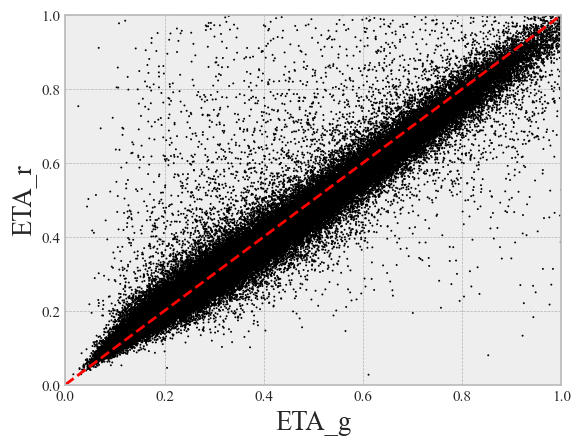

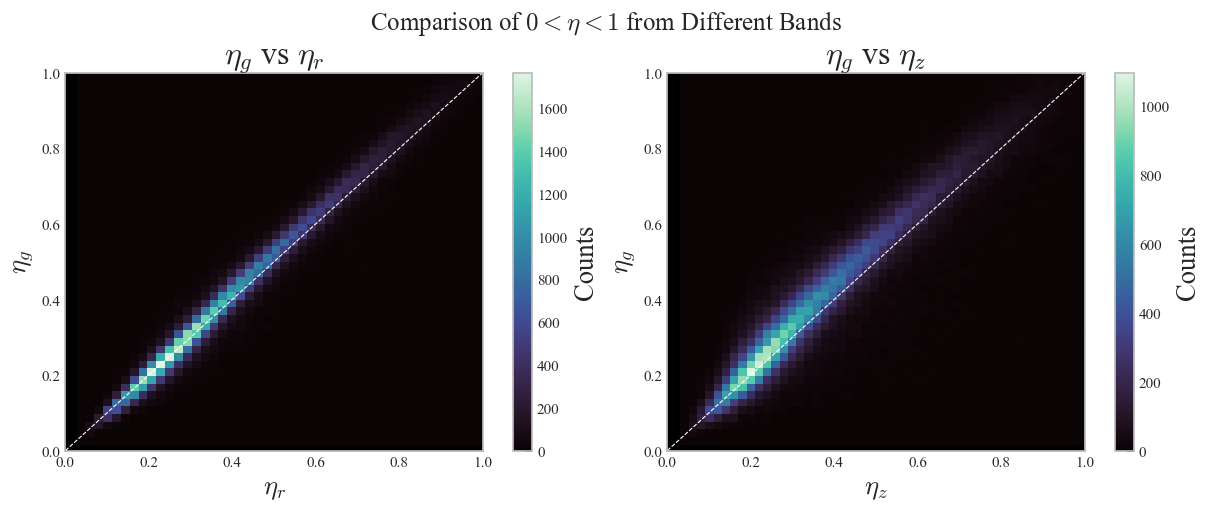

In [ ]:
# plot the eta values
plt.scatter(eta_g,eta_r,edgecolor='none',facecolor='black',s=2.)
plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.axis([0.,1,0.,1.])
plt.xlabel('ETA_g')
plt.ylabel('ETA_r')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
x=[0, 1]
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/etas.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(eta_r, eta_g, bins=100, cmap=cmap)
    axes[0].grid(False)
    axes[0].set_xlabel(r'$\eta_r$')
    axes[0].set_ylabel(r'$\eta_g$')
    axes[0].set_title(r'$\eta_g$ vs $\eta_r$')
    axes[0].set_xlim([0.,1])
    axes[0].set_ylim([0.,1])
    axes[0].set_facecolor("black")
    axes[0].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    
    

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = axes[1].hist2d(eta_z,eta_g, bins=100, cmap=cmap)
    axes[1].grid(False)
    axes[1].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    axes[1].legend(loc='upper left', fontsize=8, frameon=False)
    axes[1].set_xlabel(r'$\eta_z$')
    axes[1].set_ylabel(r'$\eta_g$')
    axes[1].set_title(r'$\eta_g$ vs $\eta_z$')
    axes[1].set_xlim([0.,1])
    axes[1].set_ylim([0.,1])
    axes[1].set_facecolor("black")
    fig.colorbar(h2[3], ax=axes[1], label='Counts')
    plt.suptitle("Comparison of $0<\eta<1$ from Different Bands", fontsize=18)
    
    pp.savefig(fig)
    

plt.show()

ValueError: x and y must be the same size

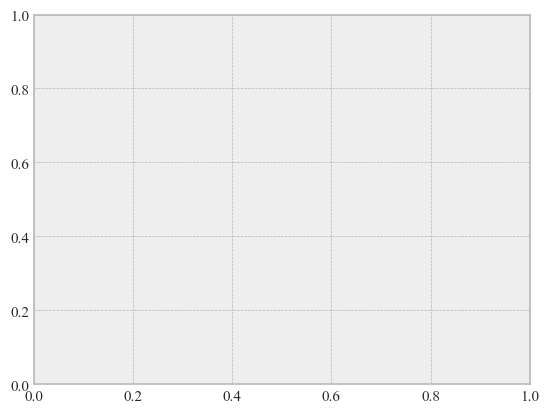

In [172]:
# plot the PA values
plt.scatter(pa_g,pa_r,edgecolor='none',facecolor='black',s=2.)
plt.plot([-3.,3],[-3.,3.],color='red',linestyle='--')
#plt.axis([0.,1,0.,1.])
plt.xlabel('PA_g')
plt.ylabel('PA_r')

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
pa_g = np.array(data['pa_g'])
pa_r = np.array(data['pa_r'])
pa_z = np.array(data['pa_z'])
pa_r_list=[]
pa_g_list=[]
pa_z_list=[]
for pa in pa_r:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_r_list.append(pa)
for pa in pa_g:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_g_list.append(pa)
for pa in pa_z:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_z_list.append(pa)
pa_r=np.array(pa_r_list)
pa_g=np.array(pa_g_list)
pa_z=np.array(pa_z_list)
    
    

with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/pa.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(pa_r,pa_g, bins=130, cmap=cmap)
    axes[0].grid(False)
    axes[0].set_xlabel(r'PA$_r$')
    axes[0].set_ylabel(r'PA$_g$')
    axes[0].set_title(r'$\eta_g$ vs $\eta_r$')

    axes[0].set_facecolor("black")
    axes[0].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    axes[0].set_title(r'Position Angle: $g$ vs $r$ Bands')
    
    

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = axes[1].hist2d(pa_z,pa_g, bins=130, cmap=cmap)
    axes[1].grid(False)
    axes[1].set_xlabel(r'PA$_z$')
    axes[1].set_ylabel(r'PA$_g$')
    axes[1].set_title(r'$\eta_g$ vs $\eta_z$')

    axes[1].set_facecolor("black")
    axes[1].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h2[3], ax=axes[1], label='Counts')
    axes[1].set_title(r'Position Angle: $g$ vs $z$ Bands')
    
    plt.suptitle("Comparison of Position Angles from Different Bands", fontsize=18)
    
    pp.savefig(fig)
    

plt.show()

In [ ]:
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/pa_inc_leda.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(pa_L,pa_g, bins=130, cmap=cmap)
    axes[0].grid(False)
    axes[0].set_xlabel(r'PA$_r$')
    axes[0].set_ylabel(r'PA$_g$')
    axes[0].set_title(r'$\eta_g$ vs $\eta_r$')

    axes[0].set_facecolor("black")
    axes[0].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    axes[0].set_title(r'Position Angle: $g$ vs $r$ Bands')
    
    

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = axes[1].hist2d(pa_z,pa_g, bins=130, cmap=cmap)
    axes[1].grid(False)
    axes[1].set_xlabel(r'PA$_z$')
    axes[1].set_ylabel(r'PA$_g$')
    axes[1].set_title(r'$\eta_g$ vs $\eta_z$')

    axes[1].set_facecolor("black")
    axes[1].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h2[3], ax=axes[1], label='Counts')
    axes[1].set_title(r'Position Angle: $g$ vs $z$ Bands')
    
    plt.suptitle("Comparison of Position Angles from Different Bands", fontsize=18)
    
    pp.savefig(fig)
    

plt.show()

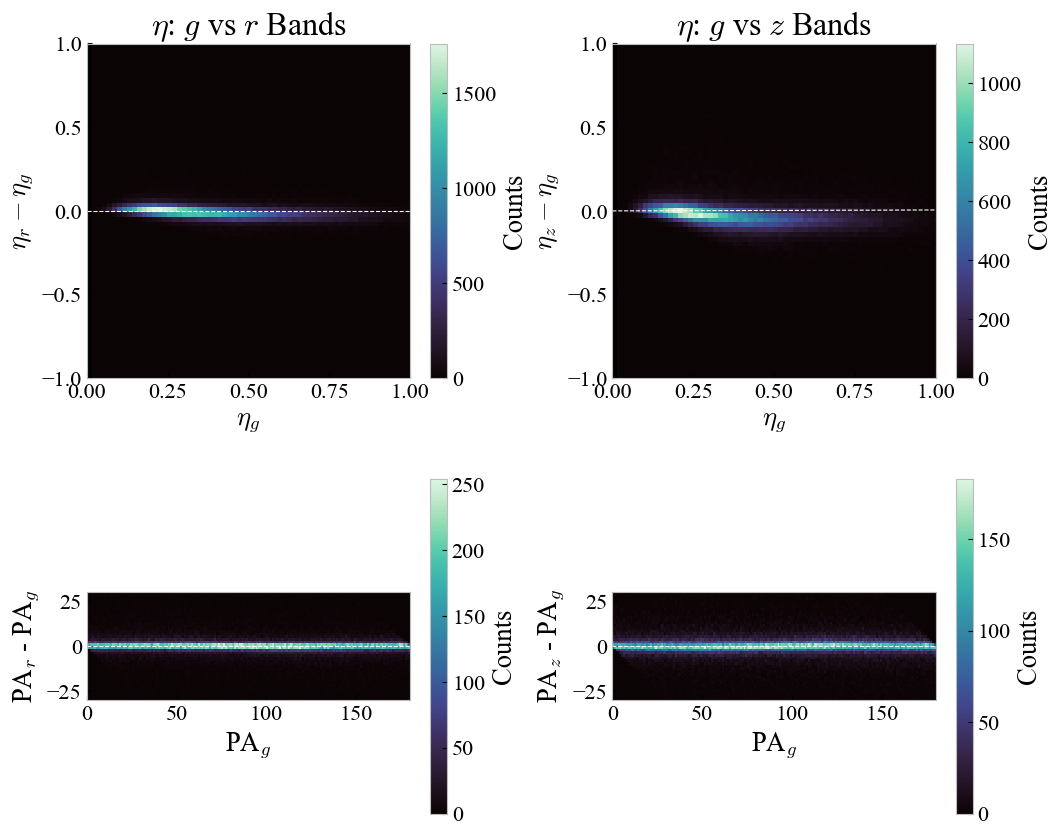

In [91]:
x = [0, 180]
pa_g = np.array(data['pa_g'])
pa_r = np.array(data['pa_r'])
pa_z = np.array(data['pa_z'])
pa_r_list=[]
pa_g_list=[]
pa_z_list=[]
for pa in pa_r:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_r_list.append(pa)
for pa in pa_g:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_g_list.append(pa)
for pa in pa_z:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_z_list.append(pa)
pa_r=np.array(pa_r_list)
pa_g=np.array(pa_g_list)
pa_z=np.array(pa_z_list)
eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)  # spacing between subplots
error_eta_g_r=np.array(eta_r)-np.array(eta_g)
error_eta_g_z=np.array(eta_z)-np.array(eta_g)
error_pa_g_r=np.array(pa_r)-np.array(pa_g)
error_pa_g_z=np.array(pa_z)-np.array(pa_g)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/news_diff_eta_pa.pdf') as pp:

    # --- (1,1): eta_r vs eta_g ---
    h1 = axes[0, 0].hist2d( eta_g,error_eta_g_r, bins=130, cmap=cmap)
   
    axes[0, 0].set_xlabel(r'$\eta_g$')
    axes[0, 0].set_ylabel(r'$\eta_r-\eta_g$')
    axes[0, 0].set_title(r'$\eta$: $g$ vs $r$ Bands')
    axes[0, 0].set_xlim([0.,1])
    axes[0, 0].set_ylim([-1,1])
    axes[0, 0].grid(False)
    axes[0, 0].plot(x, [0,0], color='white', linestyle='--', linewidth=0.8)
    axes[0, 0].set_facecolor("black")
    fig.colorbar(h1[3], ax=axes[0, 0], label='Counts')

    # --- (1,2): eta_z vs eta_g ---
    h2 = axes[0, 1].hist2d( eta_g,error_eta_g_z, bins=130, cmap=cmap)
    axes[0, 1].set_xlim([0.,1])
    axes[0, 1].set_ylim([-1,1])
    axes[0, 1].grid(False)
    axes[0, 1].plot(x, [0,1], color='white', linestyle='--', linewidth=0.8)
    axes[0, 1].set_xlabel(r'$\eta_g$')
    axes[0, 1].set_ylabel(r'$\eta_z-\eta_g$')
    axes[0, 1].set_title(r'$\eta$: $g$ vs $z$ Bands')

    axes[0, 1].set_facecolor("black")
    fig.colorbar(h2[3], ax=axes[0, 1], label='Counts')

        # --- (2,1): PA_r vs PA_g ---
    # --- (2,1): PA_r vs PA_g ---
    h3 = axes[1, 0].hist2d(pa_g, error_pa_g_r, bins=[180, 240], cmap=cmap)
    axes[1, 0].set_xlabel(r'PA$_g$')
    axes[1, 0].set_ylabel(r'PA$_r$ - PA$_g$')
    axes[1, 0].set_xlim([0, 180])
    axes[1, 0].set_ylim([-30, 30])
    axes[1, 0].grid(False)
    axes[1, 0].plot([0, 180], [0, 0], color='white', linestyle='--', linewidth=0.8)
    axes[1, 0].set_facecolor("black")
    axes[1, 0].set_aspect('equal', adjustable='box')
    fig.colorbar(h3[3], ax=axes[1, 0], label='Counts')

    # --- (2,2): PA_z vs PA_g ---

    h4 = axes[1, 1].hist2d(pa_g, error_pa_g_z, bins=[180, 240], cmap=cmap)
    axes[1, 1].set_xlabel(r'PA$_g$')
    axes[1, 1].set_ylabel(r'PA$_z$ - PA$_g$')
    axes[1, 1].set_xlim([0, 180])
    axes[1, 1].set_ylim([-30, 30])
    axes[1, 1].grid(False)
    axes[1, 1].plot([0, 180], [0, 0], color='white', linestyle='--', linewidth=0.8)
    axes[1, 1].set_facecolor("black")
    axes[1, 1].set_aspect('equal', adjustable='box')
    fig.colorbar(h4[3], ax=axes[1, 1], label='Counts')  
    
    axes[1, 0].set_aspect('equal', adjustable='box')
    axes[1, 1].set_aspect('equal', adjustable='box')
    pp.savefig(fig, bbox_inches='tight')

plt.show()

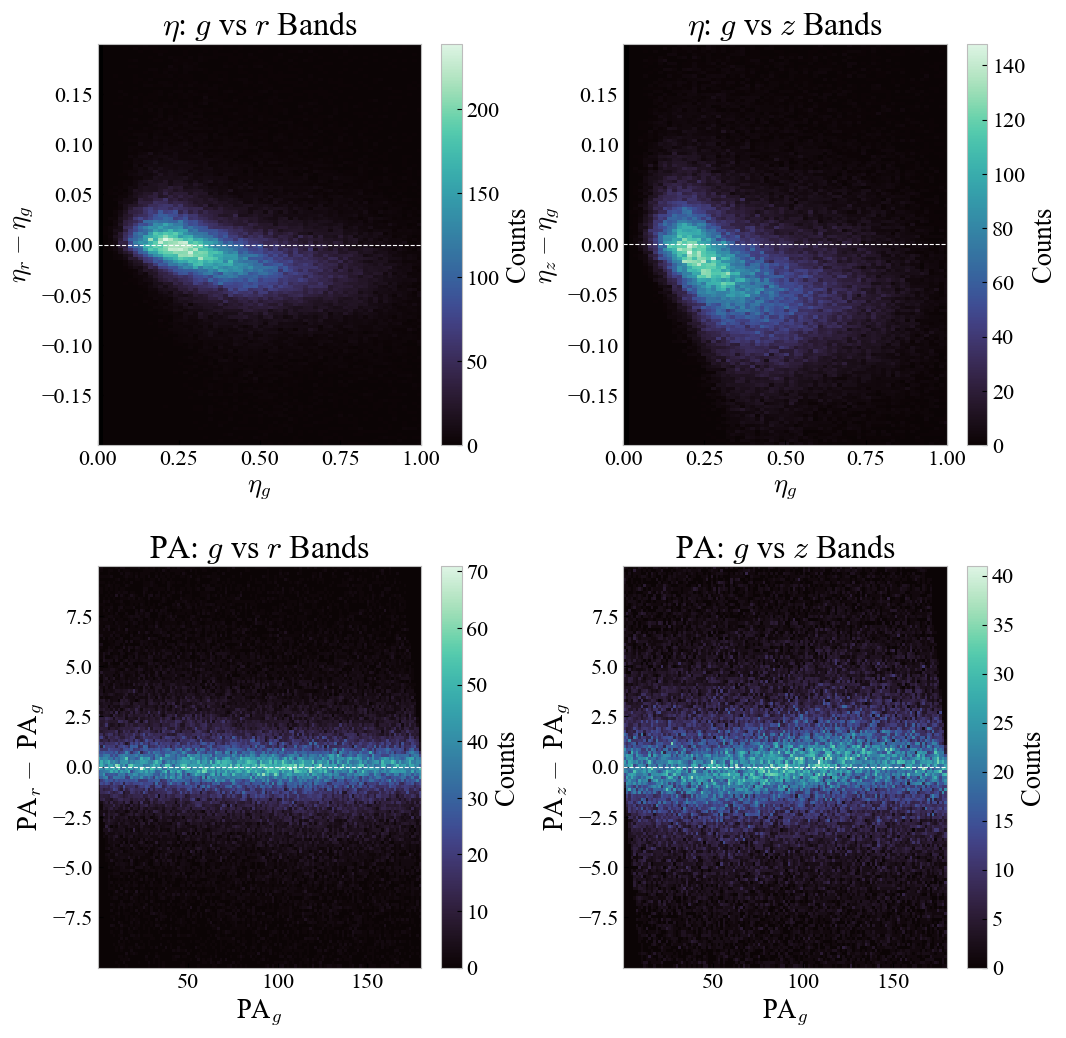

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec

# --- Example setup (you already have data + cmap defined)
x = [0, 180]

pa_g = np.array(data['pa_g'])
pa_r = np.array(data['pa_r'])
pa_z = np.array(data['pa_z'])


eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])

error_eta_g_r = eta_r - eta_g
error_eta_g_z = eta_z - eta_g
error_pa_g_r = pa_r - pa_g
error_pa_g_z = pa_z - pa_g
error_pa_g_r_best=error_pa_g_r[np.abs(error_pa_g_r)<10]
error_pa_g_z_best=error_pa_g_z[np.abs(error_pa_g_z)<10]
pa_g_best=pa_g[np.abs(error_pa_g_r)<10]
pa_g_best2=pa_g[np.abs(error_pa_g_z)<10]


error_eta_g_r_best = error_eta_g_r[np.abs(error_eta_g_r)<0.2]
error_eta_g_z_best = error_eta_g_z[np.abs( error_eta_g_z)<0.2]

eta_g_r_best=eta_g[np.abs(error_eta_g_r)<0.2]
eta_g_z_best=eta_g[np.abs( error_eta_g_z)<0.2]


# --- Create figure manually with GridSpec for custom layout
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.3)

axes = np.empty((2, 2), dtype=object)
axes[0, 0] = fig.add_subplot(gs[0, 0])
axes[0, 1] = fig.add_subplot(gs[0, 1])
axes[1, 0] = fig.add_subplot(gs[1, 0])
axes[1, 1] = fig.add_subplot(gs[1, 1])

with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/grid_news_diff_eta_pa.pdf') as pp:

    # --- η: g vs r ---
    h1 = axes[0, 0].hist2d(eta_g_r_best, error_eta_g_r_best, bins=130, cmap=cmap)
    axes[0, 0].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_r - \eta_g$', 
                   title=r'$\eta$: $g$ vs $r$ Bands', xlim=[0,1])
    axes[0, 0].plot([0,1], [0,0], 'w--', lw=0.8)
    axes[0, 0].set_facecolor("black")
    axes[0, 0].grid(False)
    fig.colorbar(h1[3], ax=axes[0, 0], label='Counts')

    # --- η: g vs z ---
    h2 = axes[0, 1].hist2d(eta_g_z_best, error_eta_g_z_best, bins=130, cmap=cmap)
    axes[0, 1].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_z - \eta_g$', 
                   title=r'$\eta$: $g$ vs $z$ Bands',xlim=[0,1])
    axes[0, 1].plot([0,1], [0,0], 'w--', lw=0.8)
    axes[0, 1].set_facecolor("black")
    axes[0, 1].grid(False)
    fig.colorbar(h2[3], ax=axes[0, 1], label='Counts')

    # --- PA: g vs r ---
    h3 = axes[1, 0].hist2d(pa_g_best, error_pa_g_r_best, bins=130, cmap=cmap)
    axes[1, 0].set(xlabel=r'PA$_g$', ylabel=r'PA$_r -$ PA$_g$', 
                   title=r'PA: $g$ vs $r$ Bands')
    axes[1, 0].plot([0,180], [0,0], 'w--', lw=0.8)
    axes[1, 0].set_facecolor("black")
#Force square data ratio
    axes[1, 0].grid(False)
    fig.colorbar(h3[3], ax=axes[1, 0], label='Counts')

    # --- PA: g vs z ---
    h4 = axes[1, 1].hist2d(pa_g_best2, error_pa_g_z_best, bins=130, cmap=cmap)
    axes[1, 1].set(xlabel=r'PA$_g$', ylabel=r'PA$_z -$ PA$_g$', 
                   title=r'PA: $g$ vs $z$ Bands')
    axes[1, 1].plot([0,180], [0,0], 'w--', lw=0.8)
    axes[1, 1].set_facecolor("black")
     # Force square data ratio
    axes[1, 1].grid(False)
    fig.colorbar(h4[3], ax=axes[1, 1], label='Counts')

    pp.savefig(fig, bbox_inches='tight')

plt.show()

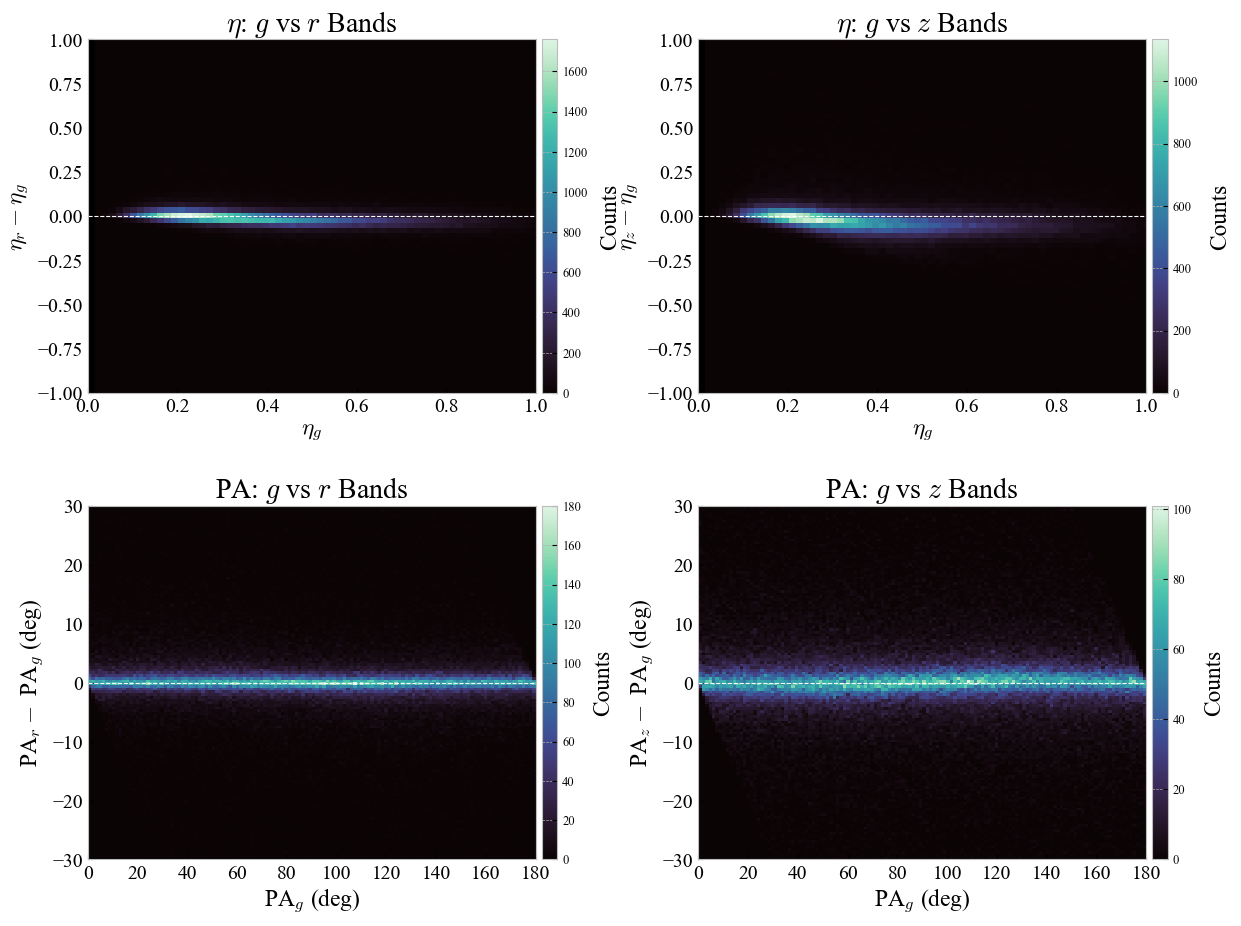

Saved to: /Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/grid_news_diff_eta_pa_equal_axes_cbars.pdf


In [147]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- data (as you had) --------------------------------------------------------
def convert_pa(arr):
    return 90 + np.degrees(arr) / 2.0

pa_g = convert_pa(np.array(data['pa_g']))
pa_r = convert_pa(np.array(data['pa_r']))
pa_z = convert_pa(np.array(data['pa_z']))

eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])

error_eta_g_r = eta_r - eta_g
error_eta_g_z = eta_z - eta_g
error_pa_g_r = pa_r - pa_g
error_pa_g_z = pa_z - pa_g

# keep PA errors within ±30°
mask_r = np.abs(error_pa_g_r) < 30
mask_z = np.abs(error_pa_g_z) < 30
pa_g_best   = pa_g[mask_r]
pa_g_best2  = pa_g[mask_z]
err_r_best  = error_pa_g_r[mask_r]
err_z_best  = error_pa_g_z[mask_z]

# --- figure: 2x2 equal-sized axes --------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=False)
axes = np.array(axes)

def add_cbar(ax, mappable, label='Counts', size='3.5%', pad=0.06, ticksize=9):
    """Append a right colorbar matched in length to ax."""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)
    cb = fig.colorbar(mappable, cax=cax)
    cb.set_label(label, labelpad=8)
    cb.ax.tick_params(labelsize=ticksize)
    return cb

# 1) η: g vs r
h1 = axes[0,0].hist2d(eta_g, error_eta_g_r, bins=130, cmap=cmap, shading='auto')
axes[0,0].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_r - \eta_g$', xlim=[0,1], ylim=[-1,1],
              title=r'$\eta$: $g$ vs $r$ Bands')
axes[0,0].plot([0,1], [0,0], 'w--', lw=0.8)
axes[0,0].set_facecolor('black'); axes[0,0].grid(False)
h1[3].set_rasterized(True)
add_cbar(axes[0,0], h1[3])

# 2) η: g vs z
h2 = axes[0,1].hist2d(eta_g, error_eta_g_z, bins=130, cmap=cmap, shading='auto')
axes[0,1].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_z - \eta_g$', xlim=[0,1], ylim=[-1,1],
              title=r'$\eta$: $g$ vs $z$ Bands')
axes[0,1].plot([0,1], [0,0], 'w--', lw=0.8)
axes[0,1].set_facecolor('black'); axes[0,1].grid(False)
h2[3].set_rasterized(True)
add_cbar(axes[0,1], h2[3])

# 3) PA: g vs r
h3 = axes[1,0].hist2d(pa_g_best, err_r_best, bins=130, cmap=cmap, shading='auto')
axes[1,0].set(xlabel=r'PA$_g$ (deg)', ylabel=r'PA$_r -$ PA$_g$ (deg)',
              xlim=[0,180], ylim=[-30,30], title=r'PA: $g$ vs $r$ Bands')
axes[1,0].plot([0,180], [0,0], 'w--', lw=0.8)
axes[1,0].set_facecolor('black'); axes[1,0].grid(False)
axes[1,0].set_xticks(np.arange(0, 181, 20))
axes[1,0].set_yticks(np.arange(-30, 31, 10))
# keep equal panel size but enforce data aspect for PA plots

h3[3].set_rasterized(True)
add_cbar(axes[1,0], h3[3])

# 4) PA: g vs z
h4 = axes[1,1].hist2d(pa_g_best2, err_z_best, bins=130, cmap=cmap, shading='auto')
axes[1,1].set(xlabel=r'PA$_g$ (deg)', ylabel=r'PA$_z -$ PA$_g$ (deg)',
              xlim=[0,180], ylim=[-30,30], title=r'PA: $g$ vs $z$ Bands')
axes[1,1].plot([0,180], [0,0], 'w--', lw=0.8)
axes[1,1].set_facecolor('black'); axes[1,1].grid(False)
axes[1,1].set_xticks(np.arange(0, 181, 20))
axes[1,1].set_yticks(np.arange(-30, 31, 10))

h4[3].set_rasterized(True)
add_cbar(axes[1,1], h4[3])

# consistent spacing and margins (keeps all panels equal-sized)
fig.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.10, wspace=0.30, hspace=0.32)

pdf_path = '/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/grid_news_diff_eta_pa_equal_axes_cbars.pdf'
with PdfPages(pdf_path) as pp:
    pp.savefig(fig, dpi=300)

plt.show()
print(f"Saved to: {pdf_path}")


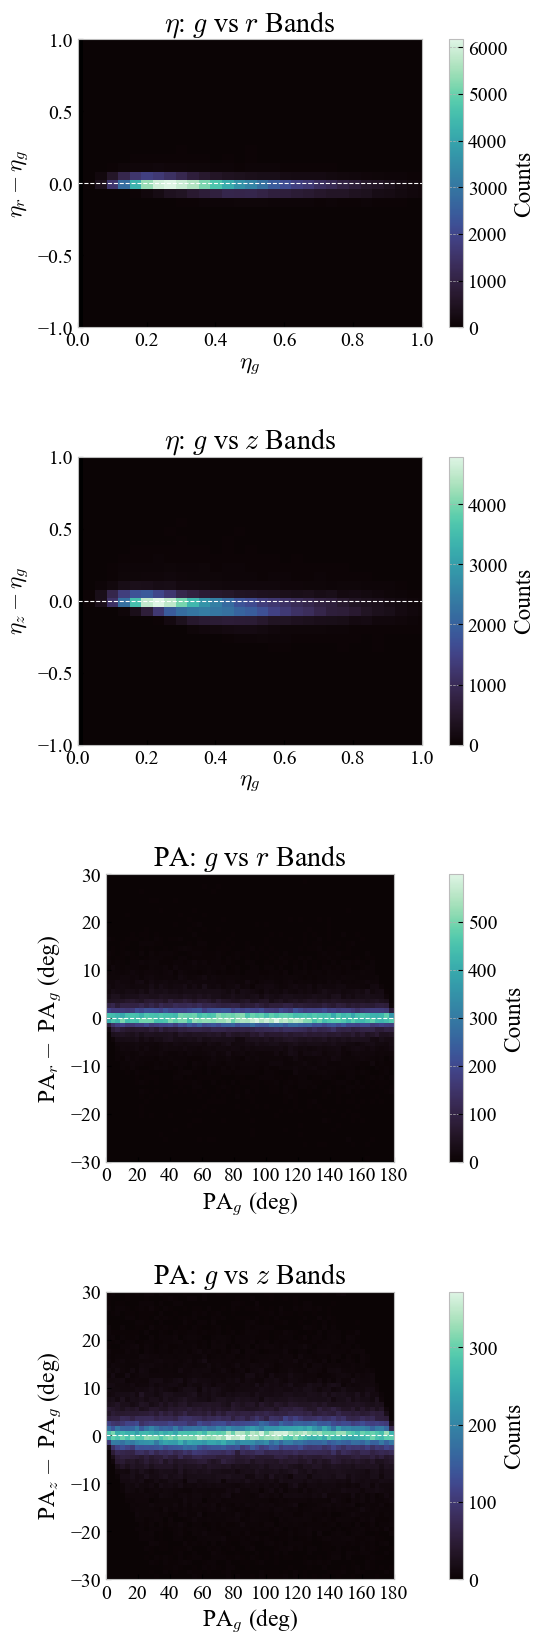

Saved to: /Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/news_diff_eta_pa_1x4_bins.pdf


In [135]:

# --- inputs assumed present: data, cmap ---------------------------------------
# angles: convert PA arrays (radians) to degrees as in your code
def convert_pa(arr):
    return 90 + np.degrees(arr) / 2.0

pa_g = convert_pa(np.array(data['pa_g']))
pa_r = convert_pa(np.array(data['pa_r']))
pa_z = convert_pa(np.array(data['pa_z']))

eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])

error_eta_g_r = eta_r - eta_g
error_eta_g_z = eta_z - eta_g
error_pa_g_r = pa_r - pa_g
error_pa_g_z = pa_z - pa_g
error_pa_g_r_best=error_pa_g_r[np.abs(error_pa_g_r)<30]
error_pa_g_z_best=error_pa_g_z[np.abs(error_pa_g_z)<30]
pa_g_best=pa_g[np.abs(error_pa_g_r)<30]
pa_g_best2=pa_g[np.abs(error_pa_g_z)<30]
# --- figure: 4 rows (plots) × 2 cols (plot + colorbar) -----------------------
fig, ax = plt.subplots(
    4, 2,
    figsize=(5, 20),
    gridspec_kw={"width_ratios": [24, 1], "hspace": 0.45, "wspace": 0.15},
    constrained_layout=False
)

pdf_path = '/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/news_diff_eta_pa_1x4_bins.pdf'
with PdfPages(pdf_path) as pp:

    # 1) η: g vs r (η_r - η_g vs η_g)
    h1 = ax[0,0].hist2d(eta_g, error_eta_g_r, bins=60, cmap=cmap, shading='auto')
    ax[0,0].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_r - \eta_g$',
                title=r'$\eta$: $g$ vs $r$ Bands', xlim=[0,1], ylim=[-1,1])
    ax[0,0].plot([0,1], [0,0], 'w--', lw=0.8)
    ax[0,0].set_facecolor('black'); ax[0,0].grid(False)
    h1[3].set_rasterized(True)
    fig.colorbar(h1[3], cax=ax[0,1], label='Counts')

    # 2) η: g vs z (η_z - η_g vs η_g)
    h2 = ax[1,0].hist2d(eta_g, error_eta_g_z, bins=60, cmap=cmap, shading='auto')
    ax[1,0].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_z - \eta_g$',
                title=r'$\eta$: $g$ vs $z$ Bands', xlim=[0,1], ylim=[-1,1])
    ax[1,0].plot([0,1], [0,0], 'w--', lw=0.8)
    ax[1,0].set_facecolor('black'); ax[1,0].grid(False)
    h2[3].set_rasterized(True)
    fig.colorbar(h2[3], cax=ax[1,1], label='Counts')

    # 3) PA: g vs r (PA_r - PA_g vs PA_g)
    h3 = ax[2,0].hist2d(pa_g_best, error_pa_g_r_best, bins=60, cmap=cmap, shading='auto')
    ax[2,0].set(xlabel=r'PA$_g$ (deg)', ylabel=r'PA$_r -$ PA$_g$ (deg)',
                title=r'PA: $g$ vs $r$ Bands', xlim=[0,180], ylim=[-30,30])
    ax[2,0].plot([0,180], [0,0], 'w--', lw=0.8)
    ax[2,0].set_facecolor('black'); ax[2,0].grid(False)
    ax[2,0].set_xticks(np.arange(0, 181, 20))
    ax[2,0].set_yticks(np.arange(-30, 31, 10))
    ax[2,0].set_aspect((180-0)/(30-(-30)))  # = 3 to get square data pixels
    h3[3].set_rasterized(True)
    fig.colorbar(h3[3], cax=ax[2,1], label='Counts')

    # 4) PA: g vs z (PA_z - PA_g vs PA_g)
    h4 = ax[3,0].hist2d(pa_g_best2, error_pa_g_z_best, bins=60, cmap=cmap, shading='auto')
    ax[3,0].set(xlabel=r'PA$_g$ (deg)', ylabel=r'PA$_z -$ PA$_g$ (deg)',
                title=r'PA: $g$ vs $z$ Bands', xlim=[0,180], ylim=[-30,30])
    ax[3,0].plot([0,180], [0,0], 'w--', lw=0.8)
    ax[3,0].set_facecolor('black'); ax[3,0].grid(False)
    ax[3,0].set_xticks(np.arange(0, 181, 20))
    ax[3,0].set_yticks(np.arange(-30, 31, 10))
    ax[3,0].set_aspect((180-0)/(30-(-30)))  # = 3
    h4[3].set_rasterized(True)
    fig.colorbar(h4[3], cax=ax[3,1], label='Counts')

    # Slightly wider left margin for mathtext-heavy labels
    fig.subplots_adjust(left=0.18, right=0.95)

    # Save without tight (to avoid cropping)
    pp.savefig(fig, dpi=300)

plt.show()
print(f"Saved to: {pdf_path}")


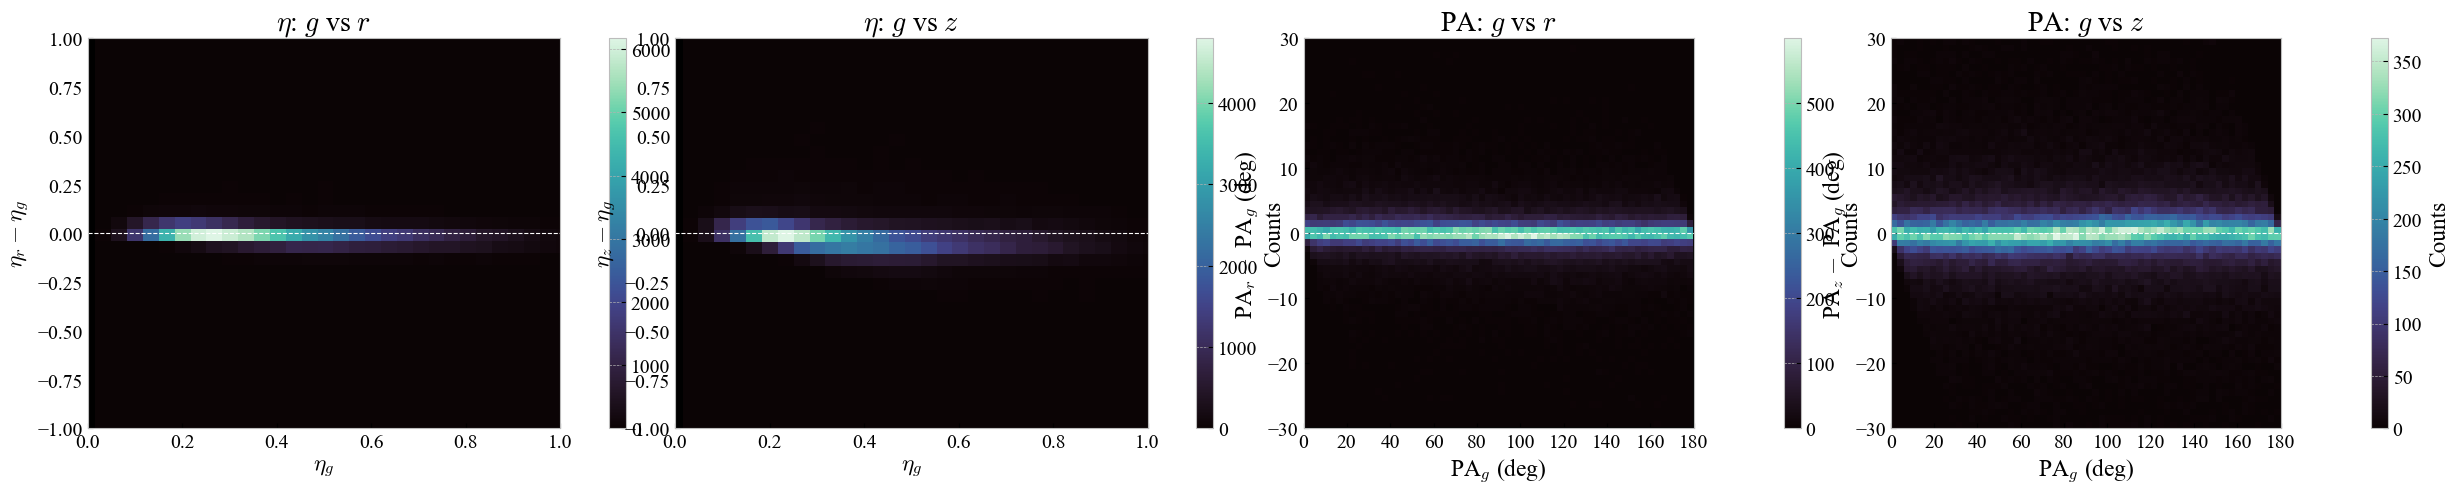

Saved to: /Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/news_diff_eta_pa_4x1_bins.pdf


In [136]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# --- Input setup (same as before) --------------------------------------------
def convert_pa(arr):
    return 90 + np.degrees(arr) / 2.0

pa_g = convert_pa(np.array(data['pa_g']))
pa_r = convert_pa(np.array(data['pa_r']))
pa_z = convert_pa(np.array(data['pa_z']))

eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])

error_eta_g_r = eta_r - eta_g
error_eta_g_z = eta_z - eta_g
error_pa_g_r = pa_r - pa_g
error_pa_g_z = pa_z - pa_g

# limit PA errors to ±30°
mask_r = np.abs(error_pa_g_r) < 30
mask_z = np.abs(error_pa_g_z) < 30
error_pa_g_r_best = error_pa_g_r[mask_r]
error_pa_g_z_best = error_pa_g_z[mask_z]
pa_g_best = pa_g[mask_r]
pa_g_best2 = pa_g[mask_z]

# --- Figure: 1 row (plots) × 8 columns (plot+colorbar for each) --------------
fig, ax = plt.subplots(
    1, 8,
    figsize=(25, 5),  # wider, shorter figure for horizontal layout
    gridspec_kw={"width_ratios": [28, 1, 28, 1, 28, 1, 28, 1],  # slim but readable cbar
        "wspace": 0.2,   # extra gap between plot & colorbar
        "hspace": 0.0},
    constrained_layout=False
)

pdf_path = '/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/news_diff_eta_pa_4x1_bins.pdf'
with PdfPages(pdf_path) as pp:

    # --- (1) η: g vs r -------------------------------------------------------
    h1 = ax[0].hist2d(eta_g, error_eta_g_r, bins=60, cmap=cmap, shading='auto')
    ax[0].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_r - \eta_g$',
              title=r'$\eta$: $g$ vs $r$', xlim=[0,1], ylim=[-1,1])
    ax[0].plot([0,1], [0,0], 'w--', lw=0.8)
    ax[0].set_facecolor('black'); ax[0].grid(False)
    h1[3].set_rasterized(True)
    fig.colorbar(h1[3], cax=ax[1], label='Counts')

    # --- (2) η: g vs z -------------------------------------------------------
    h2 = ax[2].hist2d(eta_g, error_eta_g_z, bins=60, cmap=cmap, shading='auto')
    ax[2].set(xlabel=r'$\eta_g$', ylabel=r'$\eta_z - \eta_g$',
              title=r'$\eta$: $g$ vs $z$', xlim=[0,1], ylim=[-1,1])
    ax[2].plot([0,1], [0,0], 'w--', lw=0.8)
    ax[2].set_facecolor('black'); ax[2].grid(False)
    h2[3].set_rasterized(True)
    fig.colorbar(h2[3], cax=ax[3], label='Counts')

    # --- (3) PA: g vs r ------------------------------------------------------
    h3 = ax[4].hist2d(pa_g_best, error_pa_g_r_best, bins=60, cmap=cmap, shading='auto')
    ax[4].set(xlabel=r'PA$_g$ (deg)', ylabel=r'PA$_r -$ PA$_g$ (deg)',
              title=r'PA: $g$ vs $r$', xlim=[0,180], ylim=[-30,30])
    ax[4].plot([0,180], [0,0], 'w--', lw=0.8)
    ax[4].set_facecolor('black'); ax[4].grid(False)
    ax[4].set_xticks(np.arange(0, 181, 20))
    ax[4].set_yticks(np.arange(-30, 31, 10))
    ax[4].set_aspect((180-0)/(30-(-30)))
    h3[3].set_rasterized(True)
    fig.colorbar(h3[3], cax=ax[5], label='Counts')

    # --- (4) PA: g vs z ------------------------------------------------------
    h4 = ax[6].hist2d(pa_g_best2, error_pa_g_z_best, bins=60, cmap=cmap, shading='auto')
    ax[6].set(xlabel=r'PA$_g$ (deg)', ylabel=r'PA$_z -$ PA$_g$ (deg)',
              title=r'PA: $g$ vs $z$', xlim=[0,180], ylim=[-30,30])
    ax[6].plot([0,180], [0,0], 'w--', lw=0.8)
    ax[6].set_facecolor('black'); ax[6].grid(False)
    ax[6].set_xticks(np.arange(0, 181, 20))
    ax[6].set_yticks(np.arange(-30, 31, 10))
    ax[6].set_aspect((180-0)/(30-(-30)))
    h4[3].set_rasterized(True)
    fig.colorbar(h4[3], cax=ax[7], label='Counts')

    # --- Final layout adjustments --------------------------------------------
    fig.subplots_adjust(top=0.90, bottom=0.12, left=0.06, right=0.98)
    pp.savefig(fig, dpi=300)

plt.show()
print(f"Saved to: {pdf_path}")


In [ ]:
eta_g = np.array(data['eta_g'])
eta_r = np.array(data['eta_r'])
eta_z = np.array(data['eta_z'])

scatter_eta = np.abs(np.max(np.stack((eta_g, eta_r, eta_z)), axis=0) 
                     - np.min(np.stack((eta_g, eta_r, eta_z)), axis=0))
print(np.max(scatter_eta), np.min(scatter_eta), np.median(scatter_eta), np.mean(scatter_eta))
print(len(scatter_eta))
df = pd.read_hdf('subset_data.h5', key='galaxies')
good = df.loc[df['quality_flag'] <= 3].copy()
good_eta_g = good['eta_g'].to_numpy()
good_eta_r = good['eta_r'].to_numpy()
good_eta_z = good['eta_z'].to_numpy()
good_scatter_eta = np.abs(np.max(np.stack((good_eta_g, good_eta_r, good_eta_z)), axis=0) 
                         - np.min(np.stack((good_eta_g, good_eta_r, good_eta_z)), axis=0))
print(np.max(good_scatter_eta), np.min(good_scatter_eta), np.median(good_scatter_eta), np.mean(good_scatter_eta))
print(len(good_scatter_eta))    

standard_dev_eta = np.std(scatter_eta)
print(standard_dev_eta)
good_standard_dev_eta = np.std(good_scatter_eta)
print(good_standard_dev_eta)
find_inclination_from_eta(1, A, B, C, D, E, F, verbose=True)
print(find_inclination_from_eta(0.3, A, B, C, D, E, F, verbose=True))
# Assuming you've already computed scatter_eta and attached it to df
df['scatter_eta'] = scatter_eta

# Optionally restrict to good galaxies
good = df.loc[df['quality_flag'] <= 3].copy()

# Count how many have eta difference > 1
num_large_scatter = np.sum(good['scatter_eta'] > 0.3)

print(f"Number of galaxies with η difference > 1: {num_large_scatter}")
print(f"Fraction of 'good' galaxies with η difference > 1: {num_large_scatter / len(good):.2%}")




1.8684677568265993 4.611726736579447e-05 0.05022758493193985 0.09055804665688286
115925
1.6708309500851921 4.611726736579447e-05 0.046112425103597976 0.06365687658682237
104369
0.15484270640941233
0.08539202309126705
50.39992245586565
Number of galaxies with η difference > 1: 1518
Fraction of 'good' galaxies with η difference > 1: 1.45%


In [87]:
scatter_pa = np.abs(
    np.max(np.stack((pa_g, pa_r, pa_z)), axis=0)
    - np.min(np.stack((pa_g, pa_r, pa_z)), axis=0)
)

print(np.max(scatter_pa), np.min(scatter_pa), np.median(scatter_pa), np.mean(scatter_pa))
# Attach to your DataFrame
df['scatter_pa'] = scatter_pa
print(f"standard deviation of PA scatter: {np.std(scatter_pa)}")
# Then apply your filter
good = df.loc[df['quality_flag'] <= 3].copy()
good_pa_g = good['pa_g'].to_numpy()
good_pa_r = good['pa_r'].to_numpy()
good_pa_z = good['pa_z'].to_numpy()
good_scatter_pa = np.abs(np.max(np.stack((good_pa_g, good_pa_r, good_pa_z)), axis=0) 
                         - np.min(np.stack((good_pa_g, good_pa_r, good_pa_z)), axis=0))
print(np.max(good_scatter_pa), np.min(good_scatter_pa), np.median(good_scatter_pa), np.mean(good_scatter_pa))
print(len(good_scatter_pa))
print(f"standard deviation of PA scatter: {np.std(good_scatter_pa)}")
# Now this will work:
num_large_pa_scatter = np.sum(good['scatter_pa'] > 6)

print(f"Number of galaxies with PA difference > 6: {num_large_pa_scatter}")
print(f"Fraction of 'good' galaxies with PA difference > 6: {num_large_pa_scatter / len(good):.2%}")

6.2827507021471956 0.00012194016035005362 0.08357260116709941 0.3202387099570629
standard deviation of PA scatter: 0.9427773982312176
6.2827507021471956 0.00012194016035005362 0.07769724102769704 0.28246541425438937
104369
standard deviation of PA scatter: 0.8838192537715291
Number of galaxies with PA difference > 6: 1298
Fraction of 'good' galaxies with PA difference > 6: 1.24%


In [119]:
error_eta_r_z = eta_z - eta_r
print(max(error_eta_r_z))
print(max(error_eta_g_r))
print(max(error_eta_g_z))
print(max(error_pa_g_r))
print(max(error_pa_g_z))
print(max(eta_g))
print(max(eta_r))
print(max(eta_z))
print(min(eta_g))
print(min(eta_r))
print(min(eta_z))

1.651889359123292


NameError: name 'error_eta_g_r' is not defined

In [81]:
scale_length=np.array(data['ASCALE_r'])


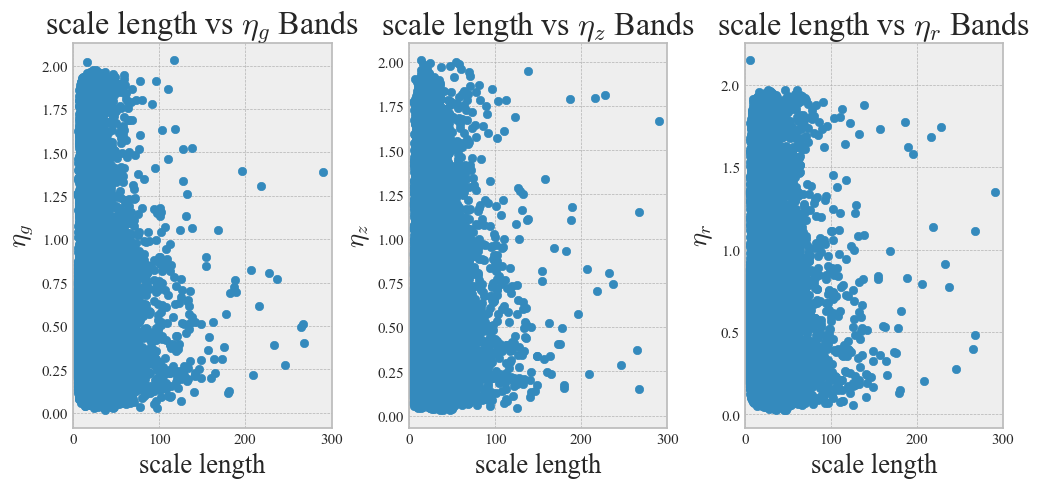

In [84]:

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/ASCALE.pdf') as pp:

    # --- (1,1): eta_r vs eta_g ---
    h1 = axes[0].scatter(scale_length, eta_g)

    axes[0].set_xlabel(r'scale length')
    axes[0].set_ylabel(r'$\eta_g$')
    axes[0].set_title(r'scale length vs $\eta_g$ Bands')
    axes[0].set_xlim([0,300])
  

    # --- (1,2): eta_z vs eta_g ---
    h2 = axes[1].scatter(scale_length, eta_z)

    axes[1].set_xlabel(r'scale length')
    axes[1].set_ylabel(r'$\eta_z$')
    axes[1].set_title(r'scale length vs $\eta_z$ Bands')
    axes[1].set_xlim([0,300])

    # --- (2,1): PA_r vs PA_g ---
    h3 = axes[2].scatter(scale_length, eta_r)

    axes[2].set_xlabel(r'scale length')
    axes[2].set_ylabel(r'$\eta_r$')
    axes[2].set_title(r'scale length vs $\eta_r$ Bands')
 
    axes[2].set_xlim([0,300])

    
    
    # --- Save to PDF ---
    pp.savefig(fig, bbox_inches='tight')

plt.show()

In [85]:
pa_leda=np.array(data['PA_LEDA'])

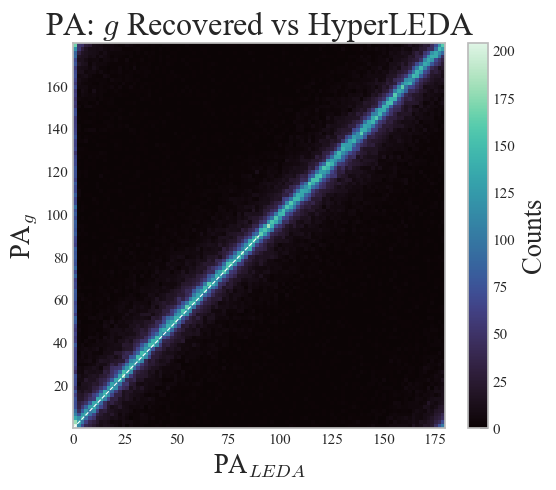

In [132]:


pa_g = np.array(data['pa_g'])
pa_leda = np.array(data['PA_LEDA'])
pa_g = np.array(good['pa_g'])
pa_leda = np.array(good['PA_LEDA'])

pa_g_list=[]
for pa in pa_g:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_g_list.append(pa)
pa_g=np.array(pa_g_list)
 
pa_g_small = np.array(pa_g[(pa_g < 165) & (pa_leda > 15)])
pa_leda_small = np.array(pa_leda[(pa_g < 165) & (pa_leda > 15)])
fig, axes=plt.subplots(1, 1, figsize=(6, 5))
with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/leda_pa_g.pdf') as pp:
    
    # --- Plot 1: eta vs b/a ---
    h1 = axes.hist2d(pa_leda,pa_g, bins=100, cmap=cmap)
    axes.grid(False)
    axes.set_xlabel(r'PA$_{LEDA}$')
    axes.set_ylabel(r'PA$_g$')
    axes.set_title(r'PA: $g$ Recovered vs HyperLEDA')

    axes.set_facecolor("black")
    axes.plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h1[3], ax=axes, label='Counts')
    
    

    pp.savefig(fig)
plt.show()

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_96200/3938043100.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper left', fontsize=8, frameon=False)


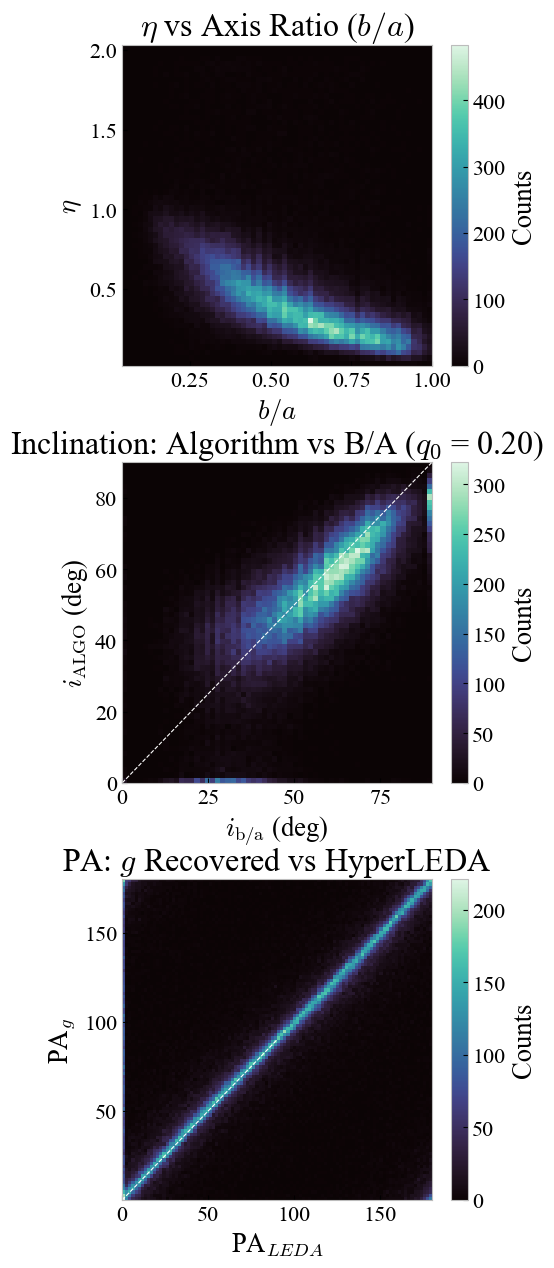

In [103]:
eta_g = np.array(data['eta_g'])
ba = np.array(data['BA_LEDA'])   
pa_leda = np.array(data['PA_LEDA'])
pa_g = np.array(data['pa_g'])
pa_g_list=[]
for pa in pa_g:
    pa=90 + (np.degrees(pa)) / 2.0
    pa_g_list.append(pa)
pa_g=np.array(pa_g_list)
fig, axes = plt.subplots( 3,1, figsize=(5, 15))
fig.subplots_adjust(wspace=0.3, hspace=0.3)  

with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/3_1pa_inc_leda.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(ba, eta_g, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[0].grid(False)
    axes[0].set_xlabel(r'$b/a$')
    axes[0].set_ylabel(r'$\eta$')
    axes[0].set_title(r'$\eta$ vs Axis Ratio ($b/a$)')
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    
    

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = axes[1].hist2d(good['INC_BA_deg'], inc_list, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[1].grid(False)
    axes[1].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    axes[1].legend(loc='upper left', fontsize=8, frameon=False)
    axes[1].set_xlabel(r'$i_{\text{b/a}}$ (deg)')
    axes[1].set_ylabel(r'$i_{\text{ALGO}}$ (deg)')
    axes[1].set_title(r'Inclination: Algorithm vs B/A ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
    fig.colorbar(h2[3], ax=axes[1], label='Counts')
    
    # --- Plot 1: eta vs b/a ---
    h3 = axes[2].hist2d(pa_leda,pa_g, bins=100, cmap=cmap)
    axes[2].grid(False)
    axes[2].set_xlabel(r'PA$_{LEDA}$')
    axes[2].set_ylabel(r'PA$_g$')
    axes[2].set_title(r'PA: $g$ Recovered vs HyperLEDA')

    axes[2].set_facecolor("black")
    axes[2].plot(x, x, color='white', linestyle='--', linewidth=0.8)
    fig.colorbar(h3[3], ax=axes[2], label='Counts')

    
    pp.savefig(fig)
    

plt.show()

In [105]:
error_pa=pa_leda - pa_g
avg_error=np.median(np.abs(error_pa))
print(avg_error)

error_inc=np.array(inc_list)-good['INC_BA_deg']
avg_error_inc=np.median(np.abs(error_inc))
print(max(error_inc))

4.941182844956018
84.03455930540953


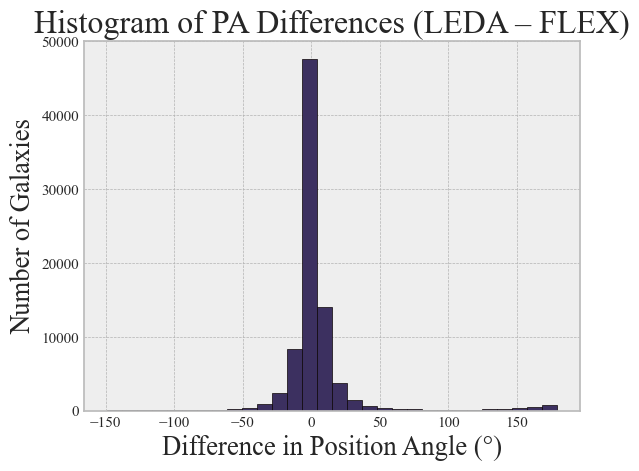

In [141]:
plt.hist(error_pa, bins=30, edgecolor=cmap(0), color=cmap(0.23))
plt.xlabel("Difference in Position Angle (°)")
plt.ylabel("Number of Galaxies")
plt.title("Histogram of PA Differences (LEDA – FLEX)")
plt.show()

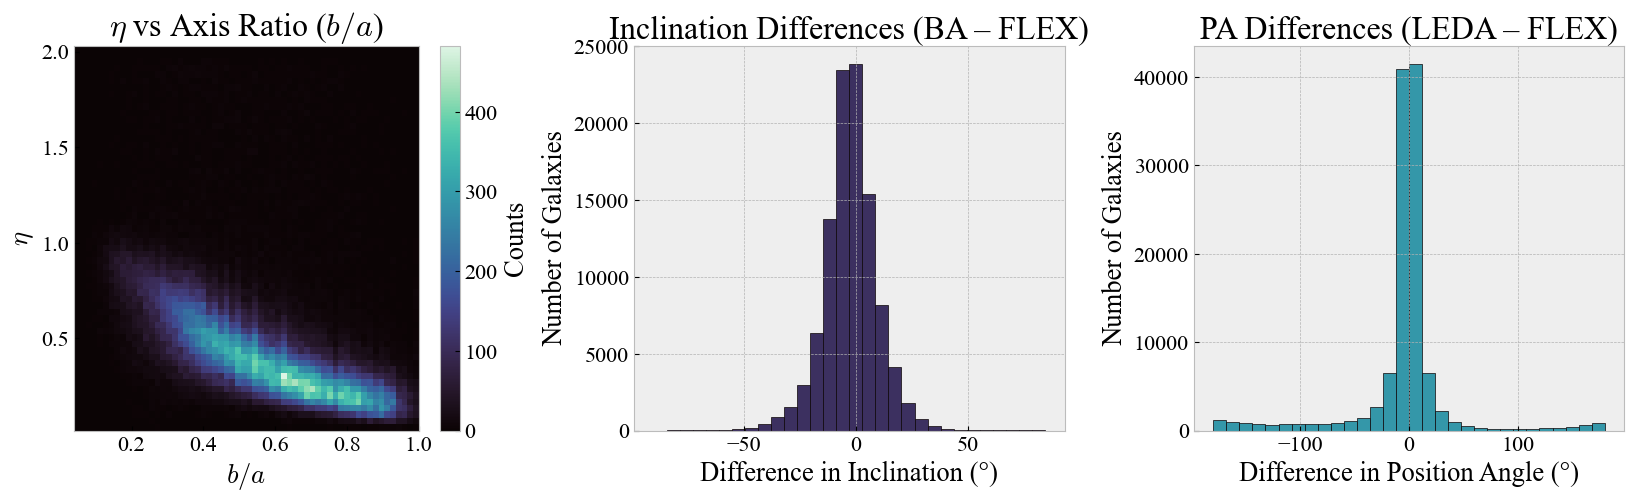

In [106]:

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)  

with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/hostpa_inc_leda.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(ba, eta_g, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[0].set_xlabel(r'$b/a$')
    axes[0].set_ylabel(r'$\eta$')
    axes[0].grid(False)
    axes[0].set_title(r'$\eta$ vs Axis Ratio ($b/a$)')
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    
    

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2= axes[1].hist(error_inc, bins=30, edgecolor=cmap(0), color=cmap(0.23))
 
    axes[1].set_xlabel(r'Difference in Inclination (°)')
    axes[1].set_ylabel(r'Number of Galaxies')
    axes[1].set_title(r'Inclination Differences (BA – FLEX)')
    
    
    h3= axes[2].hist(error_pa, bins=30, edgecolor=cmap(0), color=cmap(0.6))
    axes[2].set_xlabel("Difference in Position Angle (°)")
    axes[2].set_ylabel("Number of Galaxies")
    axes[2].set_title("PA Differences (LEDA – FLEX)")
    plt.show()

    
    pp.savefig(fig)
    

plt.show()

90.0


/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_30632/1090971609.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper left', fontsize=8, frameon=False)


NameError: name 'error_pa' is not defined

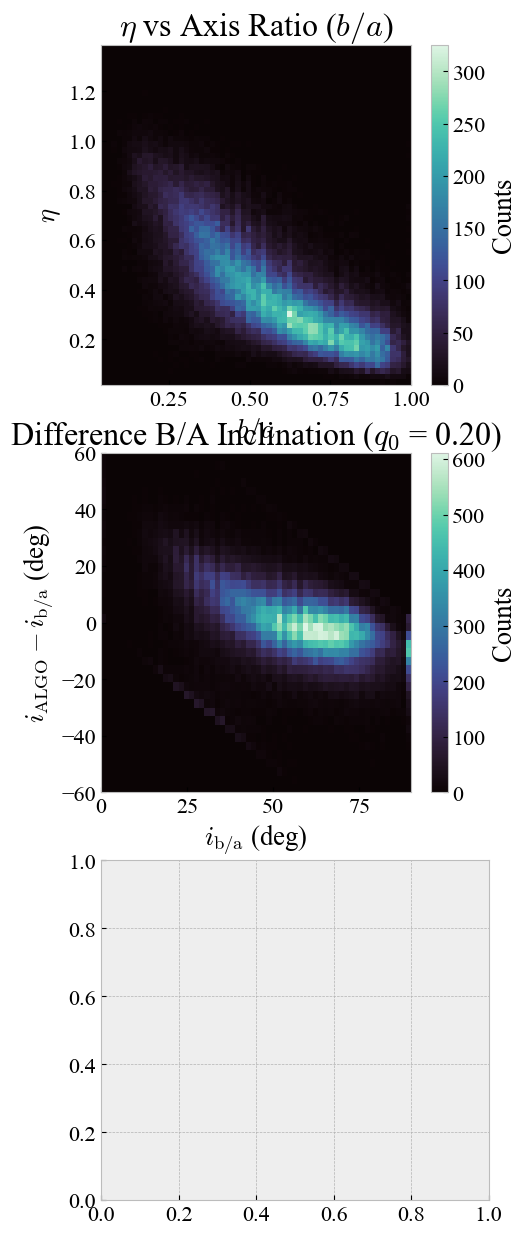

In [118]:
inc_list=[]
for i in range(len(inc_list_g)):
    inc=max(inc_list_g[i],inc_list_r[i],inc_list_z[i])
    inc_list.append(inc)

error_inc=np.array(inc_list)-good['INC_BA_deg']
avg_error_inc=np.median(np.abs(error_inc))
print(max(error_inc))
fig, axes = plt.subplots(3, 1, figsize=(5, 15))


with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/31errors_pa_inc_leda_rasters.pdf') as pp:
 
    # --- Plot 1: eta vs b/a ---
    h1 = axes[0].hist2d(ba, eta_g, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[0].grid(False)
    axes[0].set_xlabel(r'$b/a$')
    axes[0].set_rasterized(True)
    axes[0].set_ylabel(r'$\eta$')
    axes[0].set_title(r'$\eta$ vs Axis Ratio ($b/a$)')
    fig.colorbar(h1[3], ax=axes[0], label='Counts')
    
    
    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = axes[1].hist2d(good['INC_BA_deg'], error_inc, bins=60, cmap=cmap,shading='auto',edgecolor='none')
    axes[1].grid(False)
    axes[1].set_rasterized(True)
    axes[1].legend(loc='upper left', fontsize=8, frameon=False)
    axes[1].set_xlabel(r'$i_{\text{b/a}}$ (deg)')
    axes[1].set_ylabel(r'$i_{\text{ALGO}} - i_{\text{b/a}} $ (deg)')
    axes[1].set_ylim([-60,60])
    axes[1].set_title(r'Difference B/A Inclination ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
    fig.colorbar(h2[3], ax=axes[1], label='Counts')
    
    best_error_pa=error_pa[np.abs(error_pa)<30]
    best_pa_leda=pa_leda[np.abs(error_pa)<30]
    
    h3 = axes[2].hist2d(best_pa_leda, best_error_pa, bins=60, cmap=cmap)
    axes[2].grid(False)
    axes[2].set_aspect((180)/(60))
    axes[2].set_xlabel(r'PA$_{LEDA}$ (deg)')
    axes[2].set_ylabel(r'PA$_g$ - PA$_{LEDA}$ (deg)')
    axes[2].set_title(r'PA: Difference vs HyperLEDA')
    axes[2].set_rasterized(True)
    axes[2].set_xlim([0, 180])
    axes[2].set_ylim([-30, 30])
    axes[2].set_facecolor("black")

    axes[2].set_xticks(np.arange(0, 181, 20))
    axes[2].set_yticks(np.arange(-30, 31, 10))
    fig.colorbar(h3[3], ax=axes[2], label='Counts')

    
    pp.savefig(fig)
    

plt.show()

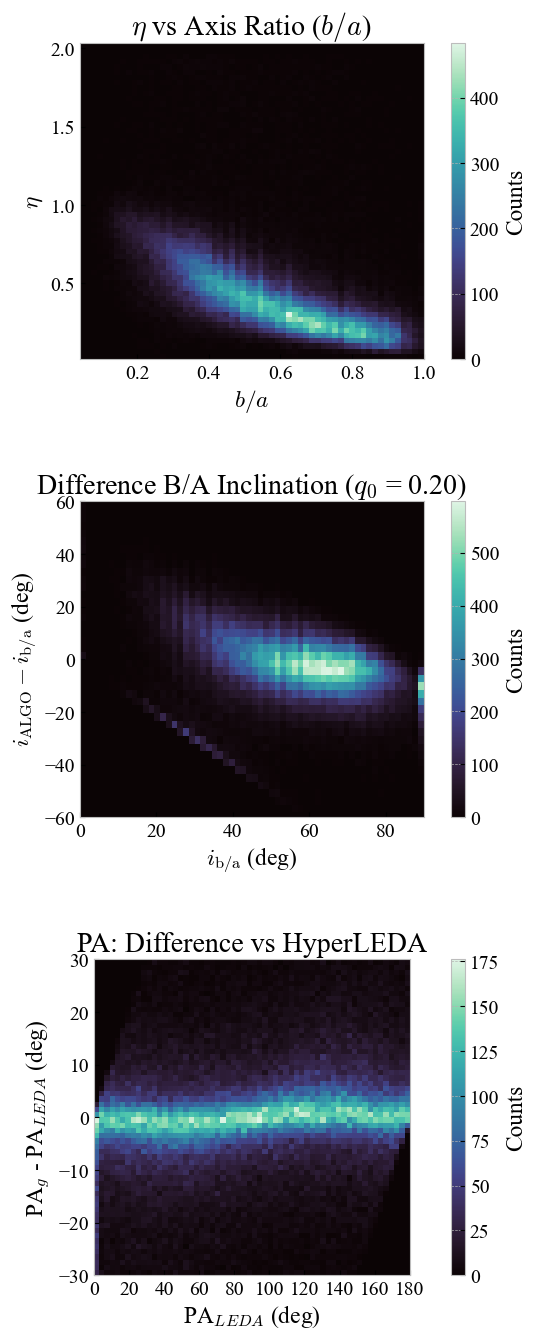

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Make a 3x2 grid: left column = plots, right column = colorbars
fig, ax = plt.subplots(
    3, 2,
    figsize=(5, 16),
    gridspec_kw={"width_ratios": [24, 1], "hspace": 0.45, "wspace": 0.15},
    constrained_layout=False  # we'll control spacing via gridspec_kw
)

with PdfPages('/Users/Megan/Desktop/Desktop/Sonification/PlotsPaper/31_errors_pa_inc_leda_rasters_grid.pdf') as pp:

    # --- Plot 1: eta vs b/a ---
    h1 = ax[0,0].hist2d(ba, eta_g, bins=60, cmap=cmap, shading='auto')
    ax[0,0].set_xlabel(r'$b/a$')
    ax[0,0].set_ylabel(r'$\eta$')
    ax[0,0].set_title(r'$\eta$ vs Axis Ratio ($b/a$)')
    ax[0,0].set_facecolor('black')
    ax[0,0].grid(False)
    h1[3].set_rasterized(True)   
    # rasterize the QuadMesh
    fig.colorbar(h1[3], cax=ax[0,1], label='Counts')

    # --- Plot 2: Algorithm vs B/A inclinations ---
    h2 = ax[1,0].hist2d(good['INC_BA_deg'], error_inc, bins=60, cmap=cmap, shading='auto')
    ax[1,0].set_xlabel(r'$i_{\text{b/a}}$ (deg)')
    ax[1,0].set_ylabel(r'$i_{\text{ALGO}} - i_{\text{b/a}}$ (deg)')
    ax[1,0].set_ylim([-60, 60])
    ax[1,0].set_title(r'Difference B/A Inclination ($q_0$ = {:.2f})'.format(Q0_DEFAULT))
    ax[1,0].set_facecolor('black')
    ax[1,0].grid(False)
    h2[3].set_rasterized(True)
    fig.colorbar(h2[3], cax=ax[1,1], label='Counts')

    # --- Plot 3: PA vs HyperLEDA ---
    sel = np.abs(error_pa) < 30
    h3 = ax[2,0].hist2d(pa_leda[sel], error_pa[sel], bins=60, cmap=cmap, shading='auto')
    ax[2,0].set_xlim(0, 180)
    ax[2,0].grid(False)
    ax[2,0].set_ylim(-30, 30)
    ax[2,0].set_aspect((180-0)/(30-(-30)))   # = 3 -> square data pixels
    ax[2,0].set_xlabel(r'PA$_{LEDA}$ (deg)')
    ax[2,0].set_ylabel(r'PA$_g$ - PA$_{LEDA}$ (deg)')
    ax[2,0].set_title(r'PA: Difference vs HyperLEDA')
    ax[2,0].set_facecolor('black')
    ax[2,0].set_xticks(np.arange(0, 181, 20))
    ax[2,0].set_yticks(np.arange(-30, 31, 10))
    h3[3].set_rasterized(True)
    fig.colorbar(h3[3], cax=ax[2,1], label='Counts')

    # give a bit more left margin for mathtext-heavy labels
    fig.subplots_adjust(left=0.18, right=0.95)

    # save without tight (tight can crop left)
    pp.savefig(fig, dpi=300)

plt.show()


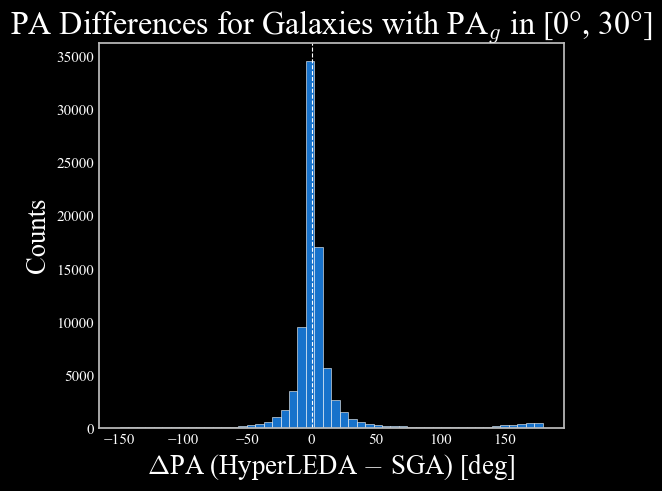

In [138]:
# Figure setup
fig, ax = plt.subplots(figsize=(6,5), facecolor='black')

# Histogram
h = ax.hist(error_pa, bins=50, color='dodgerblue', edgecolor='white', alpha=0.8)

# Style
ax.set_facecolor('black')
ax.grid(False)
ax.set_xlabel(r'$\Delta$PA (HyperLEDA $-$ SGA) [deg]', color='white')
ax.set_ylabel('Counts', color='white')
ax.set_title(r'PA Differences for Galaxies with PA$_g$ in [0°, 30°]', color='white')

# White tick labels
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Optional: vertical line for zero difference
ax.axvline(0, color='white', linestyle='--', linewidth=0.8)
